[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/example_usages/COVID_19.ipynb)

This is an example on how to predict COVID-19 spread. The goal is to predict Confirmed cases and Fatalities for future dates based on data for previous dates. 

## Table of contents

* [General description](#general_description)
* [Install and import necessary packages ](#install_and_import)
* [Get main data from Kaggle](#get_main_data)
* [Feature engineering](#features)
  * [Time delay embedding features](#time_delay_embedding_features)
  * [Day feature](#day_feature)
  * [WeekDay feature](#week_day_feature)
  * [Days since Xth Confirmed case and Xth Fatality features](#days_since_features)
  * ['Distance to Origin' feature](#distance_to_origin_feature)
  * [Functions for merging external data](#functions_for_merging)
  * [Country Area](#country_area_feature)
  * [Country population features](#country_population_features)
  * [Country Population density feature](#country_population_density_feature)
  * [Country Smoking rate feature](#country_smoking_rate_feature)
  * [Country hospital beds per 1000 people](#country_hospital_beds_feature)
  * [Country Health Expenditure](#country_health_expenditure_feature)
* [Prepare data for training](#prepare_for_training)
* [Models training](#models_training)
* [Feature importance in the models](#feature_importance)
* [Create predictions for eval and test data](#predictions)
* [Plots with predictions](#plots_with_predictions)










## General description <a name="general_description"></a>

The main data to train on is taken from https://www.kaggle.com/c/covid19-global-forecasting-week-1/data.
Regions are specified using two data fields: ``Province/State`` and ``Country/Region``.
This data is also enriched with region coordinates in ``Lat`` and ``Long`` fields.
Train data contains cumulative numbers of Confirmed cases and Fatalities for the different regions for the number of consecutive dates (contained in ``Date`` field) from 2020-01-22 to 2020-03-24. Test data is for dates from 2020-03-12 to 2020-04-23. Test data does not have Confirmed cases and Fatalities.

We will also add additional data for features from other sources:
* Country Land area from [World bank data](https://data.worldbank.org/indicator/AG.LND.TOTL.K2)
* Country Smoking rate from [World bank data](https://data.worldbank.org/indicator/SH.PRV.SMOK)
* Country Population Age and Sex distribution from [UN World Population Prospects](https://population.un.org/wpp/Download/Standard/CSV/)
* Country Hospital beds per 1000 people from [World Bank data](https://data.worldbank.org/indicator/sh.med.beds.zs)
* Country Health expenditure per Capita, PPP (current international $) from [World Bank data](https://data.worldbank.org/indicator/SH.XPD.CHEX.PP.CD) 

We will construct models that predict new cases and new fatalities (in the logarithmic scale) for the next day based on time delay embedding features for the last 30 days plus additional features from sources described above. 

For forecasting further into the future (more than a single day) we will use an incremental (by days) approach: we will use predicted values of new cases and new fatalities for days with already calculated predictions as input data for time delay embedding features for the next prediction day and then use the same procedure for the new next prediction day and so on.

# Target variables (e.g., ConfirmedCases, Fatalities)

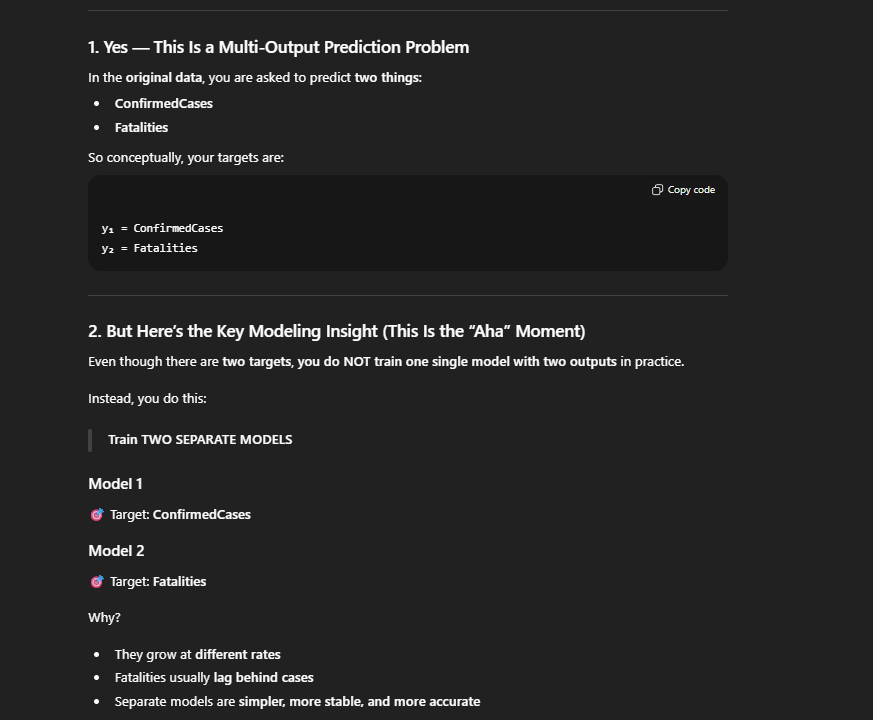  

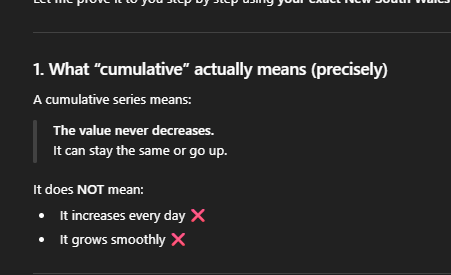  


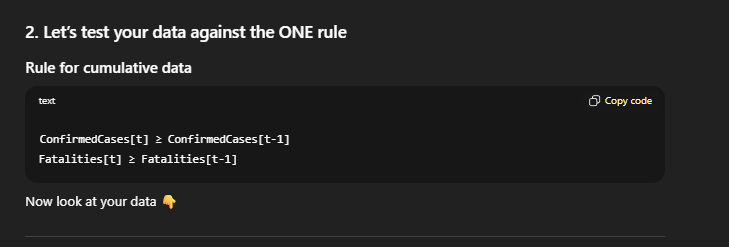

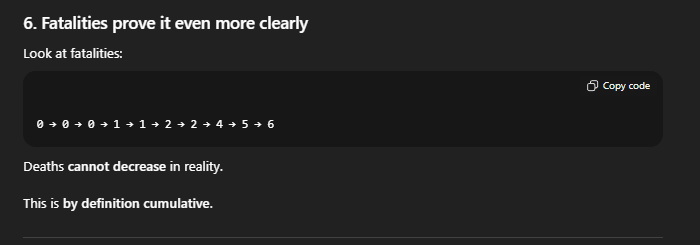

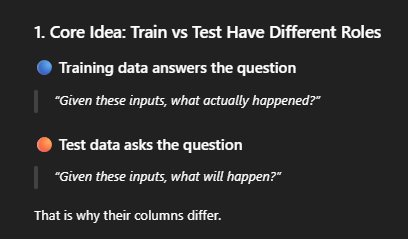   

#### If you check train.csv you have two additional columns ConfirmedCases, Fatalities which are outputs (what happened?) of the given inputs Province/State, Country/Region, Lat, Long, Date but test.csv doesn't have them because test.csv is used to predict ConfirmedCases, Fatalities (what will happen or what will be the values of ConfirmedCases and Fatalities).

#### When you use train.csv, you will split the columns from Province/State to Date for X_train and ConfirmedCases and Fatalities for y_train


#### train.csv is used to teach the model  

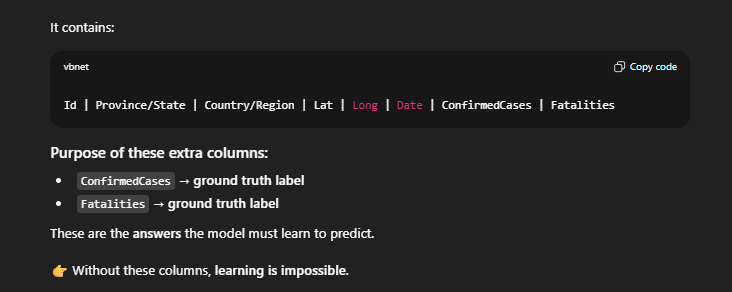

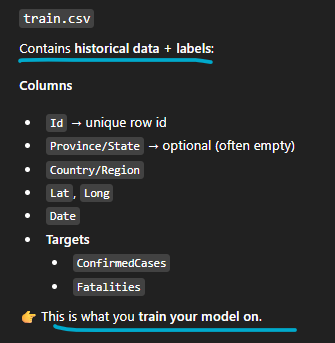  

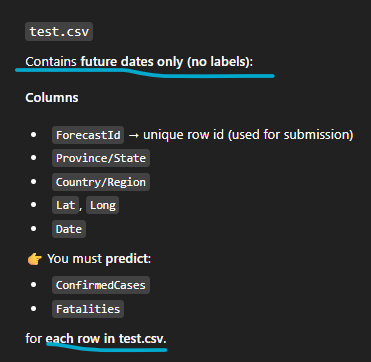

# KEY INSIGHTS

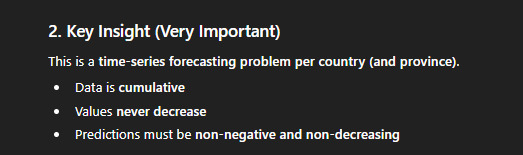

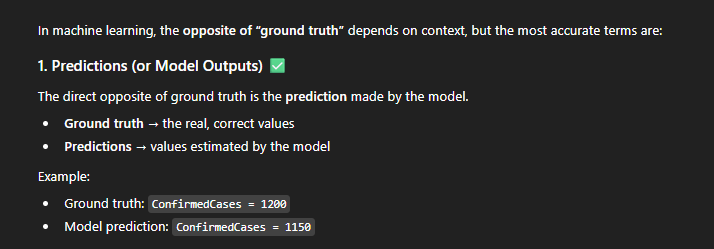

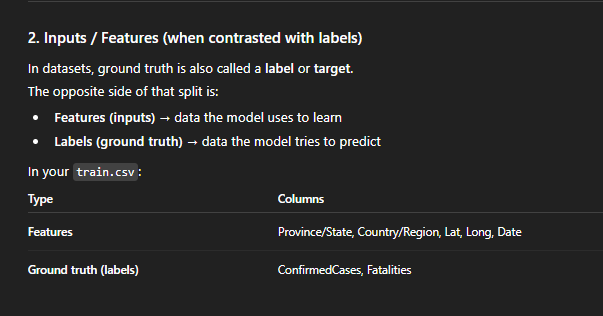

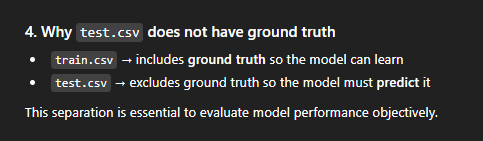

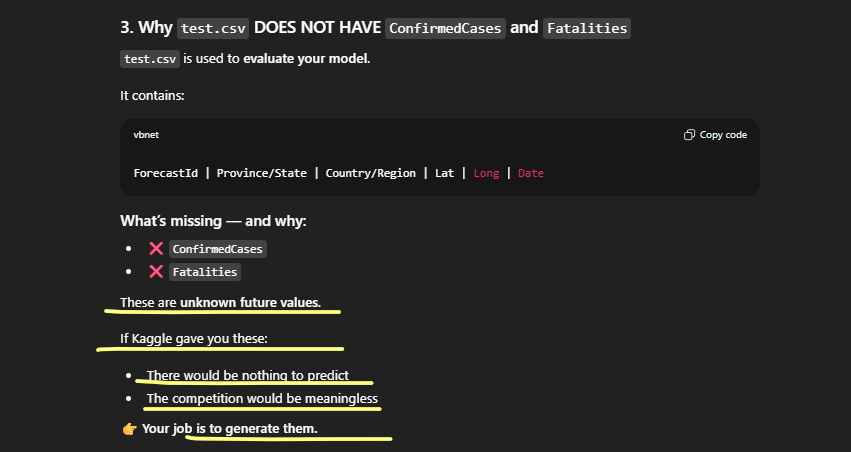

#### Ground truth = the real answers; the opposite is the model’s predictions (learned from features).

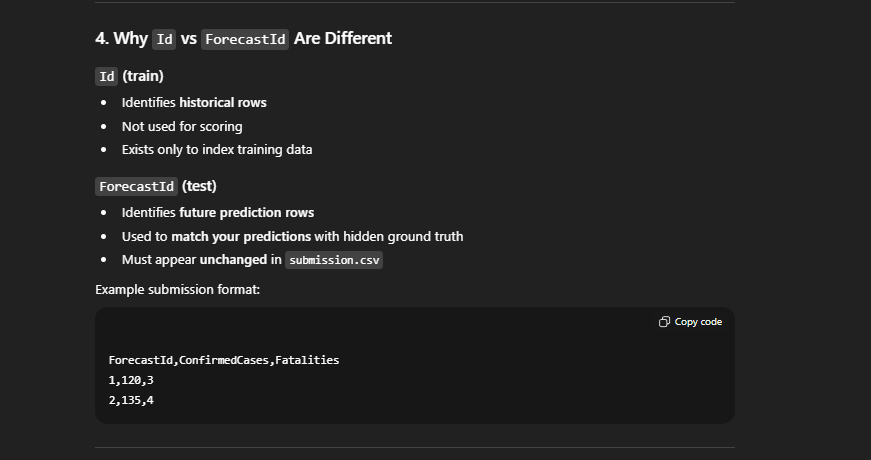

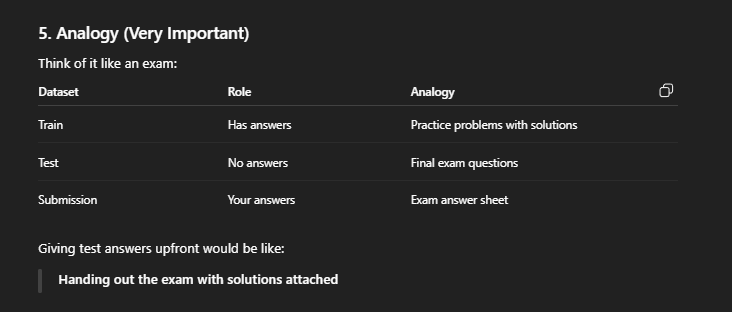

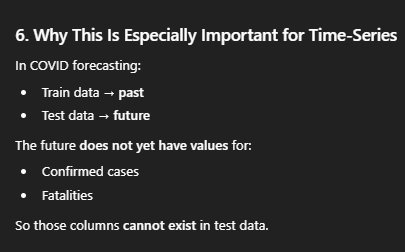

#### Train data includes labels because it teaches the model; test data excludes labels because the model must predict them.

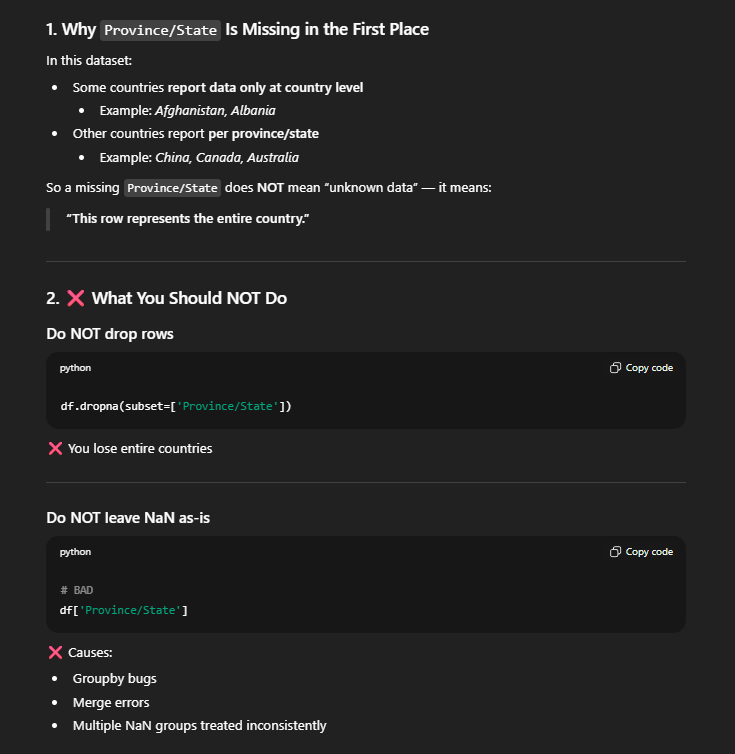  

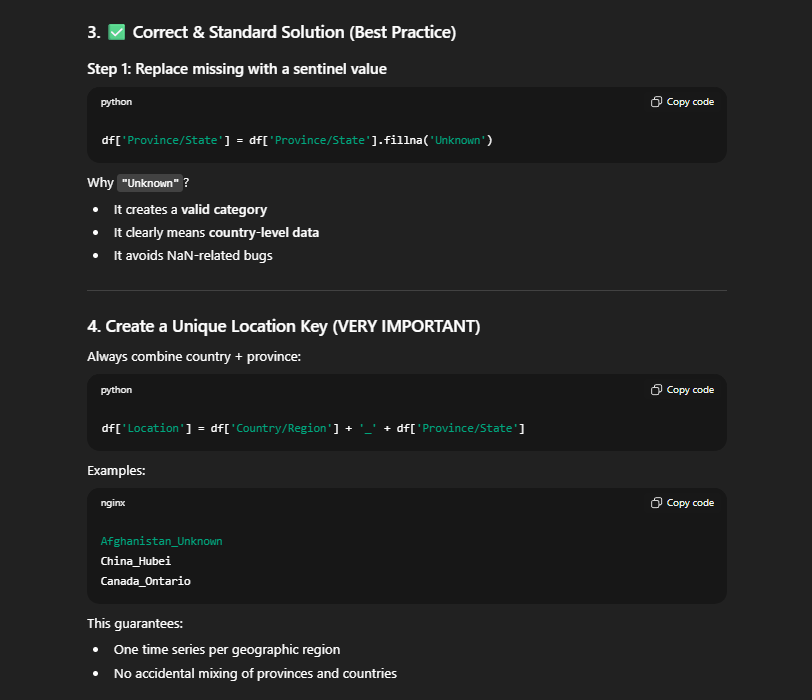  

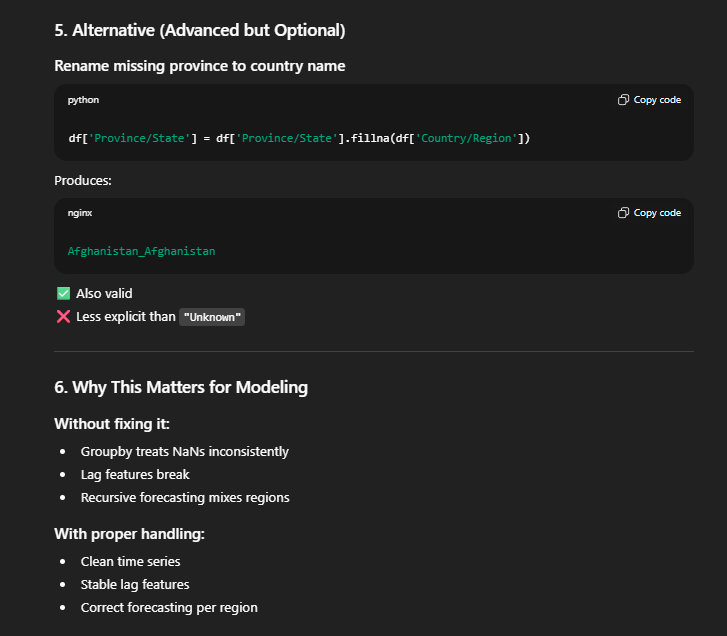    

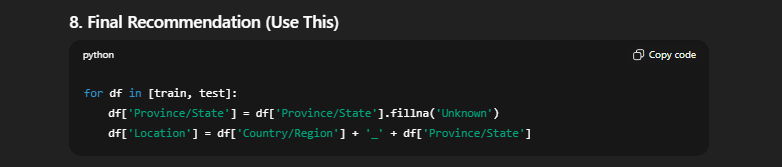

#  Step 9 : Missing Province/State means country-level data, so replace NaN with "Unknown" and always model by a combined location key.

#

## Install and import necessary packages <a name="install_and_import"></a>


In [1]:
!pip install kaggle -U
!pip install pandas -U
!pip install catboost -U

import os
import pathlib
import re

import numpy as np
import pandas as pd
import sklearn.preprocessing

import geopy.distance

import catboost as cb


Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)
     |████████████████████████████████| 64.4MB 61kB/s 


## Get main data from Kaggle <a name="get_main_data"></a>

As we download from Kaggle we need to provide Kaggle authetification cridentials. We will use the method suggested [here](https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27#gistcomment-2814834). Replace KAGGLE_USERNAME and KAGGLE_KEY with your own.

In [0]:
os.environ['KAGGLE_USERNAME'] = "XXX"
os.environ['KAGGLE_KEY'] = "YYY"

Let's download the data now.

In [3]:
kaggle_data_name = 'covid19-global-forecasting-week-1'
data_folder = os.path.join(pathlib.Path.home(), 'datasets', kaggle_data_name)

!mkdir -p ${data_folder}
!kaggle competitions download -c {kaggle_data_name} --path {data_folder}

  0% 0.00/108k [00:00<?, ?B/s]
100% 108k/108k [00:00<00:00, 23.0MB/s]
  0% 0.00/947k [00:00<?, ?B/s]
100% 947k/947k [00:00<00:00, 62.2MB/s]
  0% 0.00/540k [00:00<?, ?B/s]
100% 540k/540k [00:00<00:00, 165MB/s]


Let's check that data is ok.

In [4]:
!ls -l {data_folder}

total 1600
-rw-r--r-- 1 root root 111051 Apr 19 14:10 submission.csv
-rw-r--r-- 1 root root 552851 Apr 19 14:10 test.csv
-rw-r--r-- 1 root root 969831 Apr 19 14:10 train.csv


Let's load data to pandas.DataFrame.

In [5]:
original_train_df = pd.read_csv(os.path.join(data_folder,'train.csv'), parse_dates=['Date'])
original_train_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In [6]:
original_test_df = pd.read_csv(os.path.join(data_folder,'test.csv'), parse_dates=['Date'])
original_test_df.head()

,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16


We will concatenate original train and test dataframes for easier time delay embedding features calculations.
Original train and test data intersect by dates. We will use data from original train in the concatenated dataset for such dates.

In [7]:
last_original_train_date = original_train_df['Date'].max()
print ('last_original_train_date = ', last_original_train_date)

print ('original_test_df.shape =', original_test_df.shape)

original_test_wo_train_df = original_test_df.drop(
    index=original_test_df[original_test_df['Date'] <= last_original_train_date].index
)

print ('original_test_wo_train_df.shape =', original_test_wo_train_df.shape)

# recreate index bacause we will need unique index values later 
main_df = pd.concat([original_train_df, original_test_wo_train_df], ignore_index=True)

last_original_train_date =  2020-03-24 00:00:00
original_test_df.shape = (12212, 6)
original_test_wo_train_df.shape = (8520, 6)


There are special `Provinces` that are in fact data from Cruise ships with `Country` information. Make this ships  ``Countries`` and passengers origin country a ``Province/State`` (for proper hierarchy). 

In [8]:
from_cruise_ships = main_df['Province/State'].isin(['From Diamond Princess', 'Grand Princess'])
main_df.loc[from_cruise_ships, ['Province/State','Country/Region']] = main_df.loc[from_cruise_ships, ['Country/Region','Province/State']].values
main_df[main_df['Country/Region'].isin(['From Diamond Princess', 'Grand Princess'])]

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId
567,838.0,Australia,From Diamond Princess,35.4437,139.6380,2020-01-22,0.0,0.0,NaN
568,839.0,Australia,From Diamond Princess,35.4437,139.6380,2020-01-23,0.0,0.0,NaN
569,840.0,Australia,From Diamond Princess,35.4437,139.6380,2020-01-24,0.0,0.0,NaN
570,841.0,Australia,From Diamond Princess,35.4437,139.6380,2020-01-25,0.0,0.0,NaN
571,842.0,Australia,From Diamond Princess,35.4437,139.6380,2020-01-26,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...
24697,NaN,US,Grand Princess,37.6489,-122.6655,2020-04-19,NaN,NaN,9757.0
24698,NaN,US,Grand Princess,37.6489,-122.6655,2020-04-20,NaN,NaN,9758.0
24699,NaN,US,Grand Princess,37.6489,-122.6655,2020-04-21,NaN,NaN,9759.0
24700,NaN,US,Grand Princess,37.6489,-122.6655,2020-04-22,NaN,NaN,9760.0


## Feature engineering <a name="features"></a>

### Time delay embedding features <a name="time_delay_embedding_features"></a>

ConfirmedCases and Fatalities are transformed to the logarithmic scale ( log(1+x) to be precise ). 

Add log(1+x) - transformed number of new cases and new fatalities. Logarithmic scale is natural for this task as  the growth of this values is typically exponential.

Then add their historic values as (LogNewCases_prev_day_X, LogNewFataities_prev_day_X, X = 1 to 30) features.

Some locations contain broken data (Confirmed Cases or Fatalities contain decreasing values), remove them from data.

In [9]:
main_df.sort_values(by='Date', inplace=True)

location_columns = ['Country/Region','Province/State']

# row selection functions in pandas do not like nans
for column in location_columns:
    main_df[column].fillna('', inplace=True)


days_history_size = 30


def is_cumulative(increment_series):
    for v in increment_series:
        if (not np.isnan(v)) and (v < 0):
            return False
    return True

print ('data size before removing bad data = ', len(main_df))

for field in ['LogNewConfirmedCases', 'LogNewFatalities']:
    main_df[field] = np.nan

    for prev_day in range(1, days_history_size + 1):
        main_df[field + '_prev_day_%s' % prev_day] = np.nan


for location_name, location_df in main_df.groupby(['Country/Region', 'Province/State']):
    for field in ['ConfirmedCases', 'Fatalities']:
        new_values = location_df[field].values
        new_values[1:] -= new_values[:-1]
        if not is_cumulative(new_values):
            print ('%s for %s, %s is not valid cumulative series, drop it' % ((field,) + location_name))
            main_df.drop(index=location_df.index, inplace=True)
            break
        log_new_values = np.log1p(new_values)
        main_df.loc[location_df.index, 'LogNew' + field] = log_new_values

        for prev_day in range(1, days_history_size + 1):
            main_df.loc[location_df.index[prev_day:], 'LogNew%s_prev_day_%s' % (field, prev_day)] = (
                log_new_values[:-prev_day]
            )

print ('data size after removing bad data = ', len(main_df))
main_df.head()

data size before removing bad data =  26412
ConfirmedCases for Australia, Northern Territory is not valid cumulative series, drop it
ConfirmedCases for Australia, Queensland is not valid cumulative series, drop it
ConfirmedCases for Azerbaijan,  is not valid cumulative series, drop it
ConfirmedCases for Bahrain,  is not valid cumulative series, drop it
Fatalities for Canada, Quebec is not valid cumulative series, drop it
ConfirmedCases for China, Guizhou is not valid cumulative series, drop it
ConfirmedCases for France, France is not valid cumulative series, drop it
ConfirmedCases for France, Saint Barthelemy is not valid cumulative series, drop it
ConfirmedCases for Grand Princess, US is not valid cumulative series, drop it
ConfirmedCases for Guyana,  is not valid cumulative series, drop it
Fatalities for Iceland,  is not valid cumulative series, drop it
Fatalities for India,  is not valid cumulative series, drop it
ConfirmedCases for Japan,  is not valid cumulative series, drop it
Fa

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,LogNewConfirmedCases_prev_day_1,LogNewConfirmedCases_prev_day_2,LogNewConfirmedCases_prev_day_3,LogNewConfirmedCases_prev_day_4,LogNewConfirmedCases_prev_day_5,LogNewConfirmedCases_prev_day_6,LogNewConfirmedCases_prev_day_7,LogNewConfirmedCases_prev_day_8,LogNewConfirmedCases_prev_day_9,LogNewConfirmedCases_prev_day_10,LogNewConfirmedCases_prev_day_11,LogNewConfirmedCases_prev_day_12,LogNewConfirmedCases_prev_day_13,LogNewConfirmedCases_prev_day_14,LogNewConfirmedCases_prev_day_15,LogNewConfirmedCases_prev_day_16,LogNewConfirmedCases_prev_day_17,LogNewConfirmedCases_prev_day_18,LogNewConfirmedCases_prev_day_19,LogNewConfirmedCases_prev_day_20,LogNewConfirmedCases_prev_day_21,LogNewConfirmedCases_prev_day_22,LogNewConfirmedCases_prev_day_23,LogNewConfirmedCases_prev_day_24,LogNewConfirmedCases_prev_day_25,LogNewConfirmedCases_prev_day_26,LogNewConfirmedCases_prev_day_27,LogNewConfirmedCases_prev_day_28,LogNewConfirmedCases_prev_day_29,LogNewConfirmedCases_prev_day_30,LogNewFatalities,LogNewFatalities_prev_day_1,LogNewFatalities_prev_day_2,LogNewFatalities_prev_day_3,LogNewFatalities_prev_day_4,LogNewFatalities_prev_day_5,LogNewFatalities_prev_day_6,LogNewFatalities_prev_day_7,LogNewFatalities_prev_day_8,LogNewFatalities_prev_day_9,LogNewFatalities_prev_day_10,LogNewFatalities_prev_day_11,LogNewFatalities_prev_day_12,LogNewFatalities_prev_day_13,LogNewFatalities_prev_day_14,LogNewFatalities_prev_day_15,LogNewFatalities_prev_day_16,LogNewFatalities_prev_day_17,LogNewFatalities_prev_day_18,LogNewFatalities_prev_day_19,LogNewFatalities_prev_day_20,LogNewFatalities_prev_day_21,LogNewFatalities_prev_day_22,LogNewFatalities_prev_day_23,LogNewFatalities_prev_day_24,LogNewFatalities_prev_day_25,LogNewFatalities_prev_day_26,LogNewFatalities_prev_day_27,LogNewFatalities_prev_day_28,LogNewFatalities_prev_day_29,LogNewFatalities_prev_day_30
0,1.0,,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5544,8185.0,,Cyprus,35.1264,33.4299,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14301,21112.0,Guam,US,13.4443,144.7937,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5607,8278.0,,Czechia,49.8175,15.4730,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5670,8371.0,Denmark,Denmark,56.2639,9.5018,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Day feature <a name="day_feature"></a>

Now, add simple linear Day feature

In [0]:
first_date = min(main_df['Date'])
    
main_df['Day'] = (main_df['Date'] - first_date).dt.days.astype('int32')

### WeekDay feature <a name="week_day_feature"></a>

Let's add WeekDay feature

In [0]:
main_df['WeekDay'] = main_df['Date'].transform(lambda d: d.weekday())

### Days since Xth Confirmed case and Xth Fatality features <a name="days_since_features"></a>

Add Days since Xth Confirmed case and Xth Fatality (where X = 1, 10, 100) features

In [0]:
thresholds = [1, 10, 100]

for threshold in thresholds:
    main_df['Days_since_ConfirmedCases=%s' % threshold] = np.nan
    main_df['Days_since_Fatalities=%s' % threshold] = np.nan

for location_name, location_df in main_df.groupby(['Country/Region', 'Province/State']):
    for field in ['ConfirmedCases', 'Fatalities']:
        for threshold in thresholds:
            first_day = location_df['Day'].loc[location_df[field] >= threshold].min()
            if not np.isnan(first_day):
                main_df.loc[location_df.index, 'Days_since_%s=%s' % (field, threshold)] = (
                    location_df['Day'].transform(lambda day: -1 if (day < first_day) else (day - first_day))
                )

### 'Distance to Origin' feature. <a name="distance_to_origin_feature"></a>

Chinese province of Hubei is the original epicentre of the pandemic, so add a feature that represents distance from the region of the sample to the epidemic's origin.

In [0]:
def get_hubei_coords(df):
    for index, row in df.iterrows():
        if row['Province/State'] == 'Hubei':
            return (row['Lat'], row['Long'])

    raise Exception('Hubei not found in data')


origin_coords = get_hubei_coords(main_df)

main_df['Distance_to_origin'] = main_df.apply(
    lambda row: geopy.distance.distance((row['Lat'], row['Long']), origin_coords).km,
    axis='columns'
)


### Functions for merging external data <a name="functions_for_merging"></a>


Let's add some data from other sources.

But first, we will need a couple of helper functions with common functionality.

World bank data, UN World Population Project data and the main dataset use different names for some of the countries so we will need to remap country names in external datasets for correct merging.

In [0]:
def merge_with_column_drop(left_df, right_df, right_df_column='Country'):
    df = pd.merge(
        left=left_df,
        right=right_df,
        how='left',
        left_on='Country/Region',
        right_on=right_df_column
    )
    df.drop(columns=right_df_column, inplace=True)
    
    return df

def remap_country_name_from_world_bank_to_main_df_name(country):
    return {
        'Bahamas, The': 'The Bahamas',
        'Brunei Darussalam': 'Brunei',
        'Congo, Rep.': 'Congo (Brazzaville)',
        'Congo, Dem. Rep.': 'Congo (Kinshasa)',
        'Czech Republic': 'Czechia',
        'Egypt, Arab Rep.': 'Egypt',
        'Iran, Islamic Rep.': 'Iran',
        'Korea, Rep.': 'Korea, South',
        'Kyrgyz Republic': 'Kyrgyzstan',
        'Russian Federation': 'Russia',
        'Slovak Republic': 'Slovakia',
        'St. Lucia': 'Saint Lucia',
        'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
        'United States': 'US',
        'Venezuela, RB': 'Venezuela',
    }.get(country, country)

def remap_country_name_from_un_wpp_to_main_df_name(country):
    return {
        'Bahamas': 'The Bahamas',
        'Bolivia (Plurinational State of)': 'Bolivia',
        'Brunei Darussalam': 'Brunei',
        'China, Taiwan Province of China': 'Taiwan*',
        'Congo' : 'Congo (Brazzaville)',
        'Côte d\'Ivoire': 'Cote d\'Ivoire',
        'Democratic Republic of the Congo': 'Congo (Kinshasa)',
        'Gambia': 'The Gambia',
        'Iran (Islamic Republic of)': 'Iran',
        'Republic of Korea': 'Korea, South',
        'Republic of Moldova': 'Moldova',
        'Réunion': 'Reunion',
        'Russian Federation': 'Russia',
        'United Republic of Tanzania': 'Tanzania',
        'United States of America': 'US',
        'Venezuela (Bolivarian Republic of)': 'Venezuela',
        'Viet Nam': 'Vietnam'
    }.get(country, country)

# for read_csv
world_bank_converters={'Country Name': remap_country_name_from_world_bank_to_main_df_name}
un_wpp_converters={'Location': remap_country_name_from_un_wpp_to_main_df_name}

### Country Area <a name="country_area_feature"></a>

Let's add Country Area feature. We will use data from World Bank for that.




In [15]:
!mkdir -p area
os.chdir('area')
!wget -nc http://api.worldbank.org/v2/en/indicator/AG.LND.TOTL.K2?downloadformat=csv -O area.zip
!unzip -n area.zip  
!ls -l .

--2020-04-19 14:10:51--  http://api.worldbank.org/v2/en/indicator/AG.LND.TOTL.K2?downloadformat=csv
Resolving api.worldbank.org (api.worldbank.org)... 34.237.118.134
Connecting to api.worldbank.org (api.worldbank.org)|34.237.118.134|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19817 (19K) [application/zip]
Saving to: ‘area.zip’

area.zip            100%[===================>]  19.35K  --.-KB/s    in 0.01s   

2020-04-19 14:10:51 (1.48 MB/s) - ‘area.zip’ saved [19817/19817]

Archive:  area.zip
  inflating: Metadata_Indicator_API_AG.LND.TOTL.K2_DS2_en_csv_v2_937279.csv  
  inflating: API_AG.LND.TOTL.K2_DS2_en_csv_v2_937279.csv  
  inflating: Metadata_Country_API_AG.LND.TOTL.K2_DS2_en_csv_v2_937279.csv  
total 224
-rw-r--r-- 1 root root 169544 Apr  9 18:44 API_AG.LND.TOTL.K2_DS2_en_csv_v2_937279.csv
-rw-r--r-- 1 root root  19817 Apr 19 14:10 area.zip
-rw-r--r-- 1 root root  30906 Apr  9 18:44 Metadata_Country_API_AG.LND.TOTL.K2_DS2_en_csv_v2_937279.csv
-rw-r--r-

In [16]:
!head API_AG.LND.TOTL.K2_DS2_en_csv_v2_937279.csv


"Data Source","World Development Indicators",

"Last Updated Date","2020-04-09",

"Country Name","Country Code","Indicator Name","Indicator Code","1960","1961","1962","1963","1964","1965","1966","1967","1968","1969","1970","1971","1972","1973","1974","1975","1976","1977","1978","1979","1980","1981","1982","1983","1984","1985","1986","1987","1988","1989","1990","1991","1992","1993","1994","1995","1996","1997","1998","1999","2000","2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017","2018","2019",
"Aruba","ABW","Land area (sq. km)","AG.LND.TOTL.K2","","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","180","",
"Afghanistan","AFG","Land 

In [17]:
area_df = pd.read_csv('./API_AG.LND.TOTL.K2_DS2_en_csv_v2_937279.csv', skiprows=4, converters=world_bank_converters)
os.chdir('..')
area_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,Land area (sq. km),AG.LND.TOTL.K2,NaN,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,NaN,NaN
1,Afghanistan,AFG,Land area (sq. km),AG.LND.TOTL.K2,NaN,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,652860.0,NaN,NaN
2,Angola,AGO,Land area (sq. km),AG.LND.TOTL.K2,NaN,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,1246700.0,NaN,NaN
3,Albania,ALB,Land area (sq. km),AG.LND.TOTL.K2,NaN,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,27400.0,NaN,NaN
4,Andorra,AND,Land area (sq. km),AG.LND.TOTL.K2,NaN,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,470.0,NaN,NaN


We will use the last available data. 

In [0]:
year_columns = [str(year) for year in range(1960, 2020)]

area_df['CountryArea'] = area_df[year_columns].apply(
    lambda row: row[row.last_valid_index()] if row.last_valid_index() else np.nan,
    axis='columns'    
)

Drop unneeded columns

In [19]:
area_df = area_df[['Country Name', 'CountryArea']]
area_df.head()

,Country Name,CountryArea
0,Aruba,180.0
1,Afghanistan,652860.0
2,Angola,1246700.0
3,Albania,27400.0
4,Andorra,470.0


Now, merge this data with main data by country.



In [20]:
main_df = merge_with_column_drop(
    main_df,
    area_df,
    right_df_column='Country Name'
)
main_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,LogNewConfirmedCases_prev_day_1,LogNewConfirmedCases_prev_day_2,LogNewConfirmedCases_prev_day_3,LogNewConfirmedCases_prev_day_4,LogNewConfirmedCases_prev_day_5,LogNewConfirmedCases_prev_day_6,LogNewConfirmedCases_prev_day_7,LogNewConfirmedCases_prev_day_8,LogNewConfirmedCases_prev_day_9,LogNewConfirmedCases_prev_day_10,LogNewConfirmedCases_prev_day_11,LogNewConfirmedCases_prev_day_12,LogNewConfirmedCases_prev_day_13,LogNewConfirmedCases_prev_day_14,LogNewConfirmedCases_prev_day_15,LogNewConfirmedCases_prev_day_16,LogNewConfirmedCases_prev_day_17,LogNewConfirmedCases_prev_day_18,LogNewConfirmedCases_prev_day_19,LogNewConfirmedCases_prev_day_20,LogNewConfirmedCases_prev_day_21,LogNewConfirmedCases_prev_day_22,LogNewConfirmedCases_prev_day_23,LogNewConfirmedCases_prev_day_24,LogNewConfirmedCases_prev_day_25,LogNewConfirmedCases_prev_day_26,LogNewConfirmedCases_prev_day_27,LogNewConfirmedCases_prev_day_28,LogNewConfirmedCases_prev_day_29,LogNewConfirmedCases_prev_day_30,...,LogNewFatalities_prev_day_1,LogNewFatalities_prev_day_2,LogNewFatalities_prev_day_3,LogNewFatalities_prev_day_4,LogNewFatalities_prev_day_5,LogNewFatalities_prev_day_6,LogNewFatalities_prev_day_7,LogNewFatalities_prev_day_8,LogNewFatalities_prev_day_9,LogNewFatalities_prev_day_10,LogNewFatalities_prev_day_11,LogNewFatalities_prev_day_12,LogNewFatalities_prev_day_13,LogNewFatalities_prev_day_14,LogNewFatalities_prev_day_15,LogNewFatalities_prev_day_16,LogNewFatalities_prev_day_17,LogNewFatalities_prev_day_18,LogNewFatalities_prev_day_19,LogNewFatalities_prev_day_20,LogNewFatalities_prev_day_21,LogNewFatalities_prev_day_22,LogNewFatalities_prev_day_23,LogNewFatalities_prev_day_24,LogNewFatalities_prev_day_25,LogNewFatalities_prev_day_26,LogNewFatalities_prev_day_27,LogNewFatalities_prev_day_28,LogNewFatalities_prev_day_29,LogNewFatalities_prev_day_30,Day,WeekDay,Days_since_ConfirmedCases=1,Days_since_Fatalities=1,Days_since_ConfirmedCases=10,Days_since_Fatalities=10,Days_since_ConfirmedCases=100,Days_since_Fatalities=100,Distance_to_origin,CountryArea
0,1.0,,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,4435.232618,652860.0
1,8185.0,,Cyprus,35.1264,33.4299,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,-1.0,NaN,7177.529195,9240.0
2,21112.0,Guam,US,13.4443,144.7937,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,3851.942689,9147420.0
3,8278.0,,Czechia,49.8175,15.4730,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,7897.624038,77220.0
4,8371.0,Denmark,Denmark,56.2639,9.5018,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,7931.069186,41990.0


### Country population features <a name="country_population_features"></a>

Now, let's add country population data from UN.

In [21]:
!mkdir -p population
os.chdir('population')
!wget -nc https://population.un.org/wpp/Download/Files/1_Indicators%20\(Standard\)/CSV_FILES/WPP2019_PopulationByAgeSex_Medium.csv


--2020-04-19 14:10:59--  https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_PopulationByAgeSex_Medium.csv
Resolving population.un.org (population.un.org)... 157.150.185.69
Connecting to population.un.org (population.un.org)|157.150.185.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118543941 (113M) [application/octet-stream]
Saving to: ‘WPP2019_PopulationByAgeSex_Medium.csv’

WPP2019_PopulationB 100%[===================>] 113.05M  5.18MB/s    in 22s     

2020-04-19 14:11:21 (5.25 MB/s) - ‘WPP2019_PopulationByAgeSex_Medium.csv’ saved [118543941/118543941]



In [22]:
!head ./WPP2019_PopulationByAgeSex_Medium.csv

LocID,Location,VarID,Variant,Time,MidPeriod,AgeGrp,AgeGrpStart,AgeGrpSpan,PopMale,PopFemale,PopTotal
4,Afghanistan,2,Medium,1950,1950.5,0-4,0,5,630.044,661.578,1291.622
4,Afghanistan,2,Medium,1950,1950.5,5-9,5,5,516.206,487.335,1003.541
4,Afghanistan,2,Medium,1950,1950.5,10-14,10,5,461.378,423.326,884.704
4,Afghanistan,2,Medium,1950,1950.5,15-19,15,5,414.369,369.363,783.732
4,Afghanistan,2,Medium,1950,1950.5,20-24,20,5,374.109,318.392,692.501
4,Afghanistan,2,Medium,1950,1950.5,25-29,25,5,321.311,272.299,593.61
4,Afghanistan,2,Medium,1950,1950.5,30-34,30,5,276.279,232.168,508.447
4,Afghanistan,2,Medium,1950,1950.5,35-39,35,5,236.792,197.326,434.118
4,Afghanistan,2,Medium,1950,1950.5,40-44,40,5,200.616,167.179,367.795


In [23]:
population_df = pd.read_csv(
    'WPP2019_PopulationByAgeSex_Medium.csv',
     usecols=['Location', 'Time', 'AgeGrp', 'PopMale', 'PopFemale', 'PopTotal'],
    parse_dates=['Time'],
    converters=un_wpp_converters
)
os.chdir('..')
population_df.head()

,Location,Time,AgeGrp,PopMale,PopFemale,PopTotal
0,Afghanistan,1950-01-01,0-4,630.044,661.578,1291.622
1,Afghanistan,1950-01-01,5-9,516.206,487.335,1003.541
2,Afghanistan,1950-01-01,10-14,461.378,423.326,884.704
3,Afghanistan,1950-01-01,15-19,414.369,369.363,783.732
4,Afghanistan,1950-01-01,20-24,374.109,318.392,692.501


We will use only recent (no earlier than 2014) data



In [24]:
population_df = population_df.loc[
    (population_df['Time'] >= pd.Timestamp(2014,1,1))
    & (population_df['Time'] <= pd.Timestamp(2019,1,1))
]
population_df.head()

,Location,Time,AgeGrp,PopMale,PopFemale,PopTotal
1344,Afghanistan,2014-01-01,0-4,2803.677,2671.583,5475.260
1345,Afghanistan,2014-01-01,5-9,2635.812,2520.840,5156.652
1346,Afghanistan,2014-01-01,10-14,2356.524,2242.185,4598.709
1347,Afghanistan,2014-01-01,15-19,1995.824,1894.380,3890.204
1348,Afghanistan,2014-01-01,20-24,1580.881,1458.199,3039.080


Aggregate data by 20-year groups and also compute cumulative population.

In [25]:
aggegated_population_df = pd.DataFrame()

for (location, time), group_df in population_df.groupby(['Location', 'Time']):
    # by ['Pop_0-20', 'Pop_20-40', 'Pop_40-60', 'Pop_60-80', 'Pop_80+']
    pop_by_age_groups = [0] * 5 

    pop_male = 0
    pop_female = 0

    for _, row in group_df.iterrows():
        age_grp_start = int( re.split(r'[\-\+]', row['AgeGrp'])[0] )
        pop_by_age_groups[min(age_grp_start // 20, 4)] += row['PopMale'] + row['PopFemale']
        pop_male += row['PopMale']
        pop_female += row['PopFemale']

    ""
    aggegated_population_df = aggegated_population_df.append(
        {
            'Location': location,
            'Time': time,
            'CountryPop_0-20': pop_by_age_groups[0],
            'CountryPop_20-40': pop_by_age_groups[1],
            'CountryPop_40-60': pop_by_age_groups[2],
            'CountryPop_60-80': pop_by_age_groups[3],
            'CountryPop_80+': pop_by_age_groups[4],
            'CountryPopMale': pop_male,
            'CountryPopFemale': pop_female,
            'CountryPopTotal': pop_male + pop_female
        },
        ignore_index=True        
    )

aggegated_population_df.head()

,CountryPopFemale,CountryPopMale,CountryPopTotal,CountryPop_0-20,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,Location,Time
0,16232.001,17138.803,33370.804,19120.825,9120.269,3811.938,1232.313,85.459,Afghanistan,2014-01-01
1,16727.437,17686.166,34413.603,19506.367,9568.838,3970.149,1282.697,85.552,Afghanistan,2015-01-01
2,17196.034,18186.994,35383.028,19860.543,9972.188,4127.626,1330.040,92.631,Afghanistan,2016-01-01
3,17644.126,18651.985,36296.111,20165.546,10368.600,4286.191,1377.376,98.398,Afghanistan,2017-01-01
4,18078.879,19093.043,37171.922,20432.149,10761.931,4448.795,1426.468,102.579,Afghanistan,2018-01-01


Select the most recent data.

In [26]:
aggegated_population_df = aggegated_population_df.sort_values('Time').drop_duplicates(['Location'], keep='last')
aggegated_population_df.head()

,CountryPopFemale,CountryPopMale,CountryPopTotal,CountryPop_0-20,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,Location,Time
2417,34178.726,33351.435,67530.161,15634.443,17834.183,17763.044,12879.932,3418.559,United Kingdom,2019-01-01
2519,193337.968,196415.223,389753.191,153429.571,127412.450,75929.068,29424.842,3557.260,WB region: Middle East and North Africa (exclu...,2019-01-01
2375,265709.783,268213.492,533923.275,290642.723,149895.255,69210.044,22655.758,1519.495,UNICEF Regions: West and Central Africa,2019-01-01
2627,14469.638,14692.284,29161.922,14585.766,9617.139,3621.970,1236.095,100.952,Yemen,2019-01-01
2633,9017.820,8843.214,17861.034,9995.380,5186.638,2074.569,559.205,45.242,Zambia,2019-01-01


Now, drop Time and join with main data

In [27]:
aggegated_population_df.drop(columns='Time', inplace=True)

main_df = merge_with_column_drop(
    main_df,
    aggegated_population_df,
    right_df_column='Location'
)
main_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,LogNewConfirmedCases_prev_day_1,LogNewConfirmedCases_prev_day_2,LogNewConfirmedCases_prev_day_3,LogNewConfirmedCases_prev_day_4,LogNewConfirmedCases_prev_day_5,LogNewConfirmedCases_prev_day_6,LogNewConfirmedCases_prev_day_7,LogNewConfirmedCases_prev_day_8,LogNewConfirmedCases_prev_day_9,LogNewConfirmedCases_prev_day_10,LogNewConfirmedCases_prev_day_11,LogNewConfirmedCases_prev_day_12,LogNewConfirmedCases_prev_day_13,LogNewConfirmedCases_prev_day_14,LogNewConfirmedCases_prev_day_15,LogNewConfirmedCases_prev_day_16,LogNewConfirmedCases_prev_day_17,LogNewConfirmedCases_prev_day_18,LogNewConfirmedCases_prev_day_19,LogNewConfirmedCases_prev_day_20,LogNewConfirmedCases_prev_day_21,LogNewConfirmedCases_prev_day_22,LogNewConfirmedCases_prev_day_23,LogNewConfirmedCases_prev_day_24,LogNewConfirmedCases_prev_day_25,LogNewConfirmedCases_prev_day_26,LogNewConfirmedCases_prev_day_27,LogNewConfirmedCases_prev_day_28,LogNewConfirmedCases_prev_day_29,LogNewConfirmedCases_prev_day_30,...,LogNewFatalities_prev_day_9,LogNewFatalities_prev_day_10,LogNewFatalities_prev_day_11,LogNewFatalities_prev_day_12,LogNewFatalities_prev_day_13,LogNewFatalities_prev_day_14,LogNewFatalities_prev_day_15,LogNewFatalities_prev_day_16,LogNewFatalities_prev_day_17,LogNewFatalities_prev_day_18,LogNewFatalities_prev_day_19,LogNewFatalities_prev_day_20,LogNewFatalities_prev_day_21,LogNewFatalities_prev_day_22,LogNewFatalities_prev_day_23,LogNewFatalities_prev_day_24,LogNewFatalities_prev_day_25,LogNewFatalities_prev_day_26,LogNewFatalities_prev_day_27,LogNewFatalities_prev_day_28,LogNewFatalities_prev_day_29,LogNewFatalities_prev_day_30,Day,WeekDay,Days_since_ConfirmedCases=1,Days_since_Fatalities=1,Days_since_ConfirmedCases=10,Days_since_Fatalities=10,Days_since_ConfirmedCases=100,Days_since_Fatalities=100,Distance_to_origin,CountryArea,CountryPopFemale,CountryPopMale,CountryPopTotal,CountryPop_0-20,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+
0,1.0,,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,4435.232618,652860.0,18512.030,19529.727,38041.757,20676.365,11160.511,4620.268,1479.526,105.087
1,8185.0,,Cyprus,35.1264,33.4299,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,-1.0,NaN,7177.529195,9240.0,599.277,599.297,1198.574,275.284,382.653,308.911,193.202,38.524
2,21112.0,Guam,US,13.4443,144.7937,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,3851.942689,9147420.0,166238.618,162826.299,329064.917,82289.916,90159.134,82846.126,60854.332,12915.409
3,8278.0,,Czechia,49.8175,15.4730,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,7897.624038,77220.0,5428.585,5260.628,10689.213,2152.923,2656.340,3107.360,2332.215,440.375
4,8371.0,Denmark,Denmark,56.2639,9.5018,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,7931.069186,41990.0,2902.205,2869

### Country Population density feature <a name="country_population_density_feature"></a>

With both Area and Population data we can now compute Population density feature.

In [0]:
main_df['CountryPopDensity'] = main_df['CountryPopTotal'] / main_df['CountryArea']

### Country Smoking rate feature <a name="country_smoking_rate_feature"></a>

Let's also add Smoking rate by Country data because smoking can influence the severity of respiratory diseases.

In [29]:
!mkdir -p smoking
os.chdir('smoking')
!wget -nc http://api.worldbank.org/v2/en/indicator/SH.PRV.SMOK?downloadformat=csv -O smoking.zip
!unzip -n smoking.zip  
!ls -l .

--2020-04-19 14:11:51--  http://api.worldbank.org/v2/en/indicator/SH.PRV.SMOK?downloadformat=csv
Resolving api.worldbank.org (api.worldbank.org)... 107.23.127.3
Connecting to api.worldbank.org (api.worldbank.org)|107.23.127.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18137 (18K) [application/zip]
Saving to: ‘smoking.zip’

smoking.zip         100%[===================>]  17.71K  --.-KB/s    in 0.01s   

2020-04-19 14:11:51 (1.41 MB/s) - ‘smoking.zip’ saved [18137/18137]

Archive:  smoking.zip
  inflating: Metadata_Indicator_API_SH.PRV.SMOK_DS2_en_csv_v2_937317.csv  
  inflating: API_SH.PRV.SMOK_DS2_en_csv_v2_937317.csv  
  inflating: Metadata_Country_API_SH.PRV.SMOK_DS2_en_csv_v2_937317.csv  
total 136
-rw-r--r-- 1 root root 78878 Apr  9 18:50 API_SH.PRV.SMOK_DS2_en_csv_v2_937317.csv
-rw-r--r-- 1 root root 30906 Apr  9 18:50 Metadata_Country_API_SH.PRV.SMOK_DS2_en_csv_v2_937317.csv
-rw-r--r-- 1 root root   447 Apr  9 18:50 Metadata_Indicator_API_SH.PRV.SMOK

In [30]:
!head API_SH.PRV.SMOK_DS2_en_csv_v2_937317.csv

"Data Source","World Development Indicators",

"Last Updated Date","2020-04-09",

"Country Name","Country Code","Indicator Name","Indicator Code","1960","1961","1962","1963","1964","1965","1966","1967","1968","1969","1970","1971","1972","1973","1974","1975","1976","1977","1978","1979","1980","1981","1982","1983","1984","1985","1986","1987","1988","1989","1990","1991","1992","1993","1994","1995","1996","1997","1998","1999","2000","2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017","2018","2019",
"Aruba","ABW","Smoking prevalence, total (ages 15+)","SH.PRV.SMOK","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","",
"Afghanistan","AFG","Smoking prevalence, total (ages 15+)","SH.PRV.SMOK","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","

In [31]:
smoking_df = pd.read_csv('./API_SH.PRV.SMOK_DS2_en_csv_v2_937317.csv', skiprows=4)
os.chdir('..')
smoking_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"Smoking prevalence, total (ages 15+)",SH.PRV.SMOK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,"Smoking prevalence, total (ages 15+)",SH.PRV.SMOK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,"Smoking prevalence, total (ages 15+)",SH.PRV.SMOK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,"Smoking prevalence, total (ages 15+)",SH.PRV.SMOK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.8,NaN,NaN,NaN,NaN,32.7,NaN,NaN,NaN,NaN,31.2,30.7,30.2,29.8,29.5,29.1,28.7,NaN,NaN,NaN,NaN
4,Andorra,AND,"Smoking prevalence, total (ages 15+)",SH.PRV.SMOK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.4,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,34.8,34.5,34.2,34.1,33.9,33.7,33.5,NaN,NaN,NaN,NaN


We will use the last available data from recent years (2010 and later). 

In [0]:
recent_year_columns = [str(year) for year in range(2010, 2020)]

smoking_df['CountrySmokingRate'] = smoking_df[recent_year_columns].apply(
    lambda row: row[row.last_valid_index()] if row.last_valid_index() else np.nan,
    axis='columns'    
)

Drop unneeded columns

In [33]:
smoking_df = smoking_df[['Country Name', 'CountrySmokingRate']]
smoking_df.head()

,Country Name,CountrySmokingRate
0,Aruba,NaN
1,Afghanistan,NaN
2,Angola,NaN
3,Albania,28.7
4,Andorra,33.5


Now, merge this data with main data by country.

In [34]:
main_df = merge_with_column_drop(
    main_df,
    smoking_df,
    right_df_column='Country Name'
)
main_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,LogNewConfirmedCases_prev_day_1,LogNewConfirmedCases_prev_day_2,LogNewConfirmedCases_prev_day_3,LogNewConfirmedCases_prev_day_4,LogNewConfirmedCases_prev_day_5,LogNewConfirmedCases_prev_day_6,LogNewConfirmedCases_prev_day_7,LogNewConfirmedCases_prev_day_8,LogNewConfirmedCases_prev_day_9,LogNewConfirmedCases_prev_day_10,LogNewConfirmedCases_prev_day_11,LogNewConfirmedCases_prev_day_12,LogNewConfirmedCases_prev_day_13,LogNewConfirmedCases_prev_day_14,LogNewConfirmedCases_prev_day_15,LogNewConfirmedCases_prev_day_16,LogNewConfirmedCases_prev_day_17,LogNewConfirmedCases_prev_day_18,LogNewConfirmedCases_prev_day_19,LogNewConfirmedCases_prev_day_20,LogNewConfirmedCases_prev_day_21,LogNewConfirmedCases_prev_day_22,LogNewConfirmedCases_prev_day_23,LogNewConfirmedCases_prev_day_24,LogNewConfirmedCases_prev_day_25,LogNewConfirmedCases_prev_day_26,LogNewConfirmedCases_prev_day_27,LogNewConfirmedCases_prev_day_28,LogNewConfirmedCases_prev_day_29,LogNewConfirmedCases_prev_day_30,...,LogNewFatalities_prev_day_11,LogNewFatalities_prev_day_12,LogNewFatalities_prev_day_13,LogNewFatalities_prev_day_14,LogNewFatalities_prev_day_15,LogNewFatalities_prev_day_16,LogNewFatalities_prev_day_17,LogNewFatalities_prev_day_18,LogNewFatalities_prev_day_19,LogNewFatalities_prev_day_20,LogNewFatalities_prev_day_21,LogNewFatalities_prev_day_22,LogNewFatalities_prev_day_23,LogNewFatalities_prev_day_24,LogNewFatalities_prev_day_25,LogNewFatalities_prev_day_26,LogNewFatalities_prev_day_27,LogNewFatalities_prev_day_28,LogNewFatalities_prev_day_29,LogNewFatalities_prev_day_30,Day,WeekDay,Days_since_ConfirmedCases=1,Days_since_Fatalities=1,Days_since_ConfirmedCases=10,Days_since_Fatalities=10,Days_since_ConfirmedCases=100,Days_since_Fatalities=100,Distance_to_origin,CountryArea,CountryPopFemale,CountryPopMale,CountryPopTotal,CountryPop_0-20,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,CountryPopDensity,CountrySmokingRate
0,1.0,,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,4435.232618,652860.0,18512.030,19529.727,38041.757,20676.365,11160.511,4620.268,1479.526,105.087,0.058269,NaN
1,8185.0,,Cyprus,35.1264,33.4299,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,-1.0,NaN,7177.529195,9240.0,599.277,599.297,1198.574,275.284,382.653,308.911,193.202,38.524,0.129716,36.4
2,21112.0,Guam,US,13.4443,144.7937,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,3851.942689,9147420.0,166238.618,162826.299,329064.917,82289.916,90159.134,82846.126,60854.332,12915.409,0.035974,NaN
3,8278.0,,Czechia,49.8175,15.4730,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,7897.624038,77220.0,5428.585,5260.628,10689.213,2152.923,2656.340,3107.360,2332.215,440.375,0.138425,NaN
4,8371.0,Denmark,Denmark,56.2639,9.5018,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,7931.069186,41990.0,2902.205,2869.672,57

### Country hospital beds per 1000 people <a name="country_hospital_beds_feature"></a>

Let's add some information about countries' health system.

We will add the number of hospital beds per 1000 people first.

In [35]:
!mkdir -p hospital_beds
os.chdir('hospital_beds')
!wget -nc http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv -O hospital_beds.zip
!unzip -n hospital_beds.zip  
!ls -l .

--2020-04-19 14:12:00--  http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv
Resolving api.worldbank.org (api.worldbank.org)... 107.23.127.3
Connecting to api.worldbank.org (api.worldbank.org)|107.23.127.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33566 (33K) [application/zip]
Saving to: ‘hospital_beds.zip’

hospital_beds.zip   100%[===================>]  32.78K  --.-KB/s    in 0.01s   

2020-04-19 14:12:00 (2.52 MB/s) - ‘hospital_beds.zip’ saved [33566/33566]

Archive:  hospital_beds.zip
  inflating: Metadata_Indicator_API_SH.MED.BEDS.ZS_DS2_en_csv_v2_935968.csv  
  inflating: API_SH.MED.BEDS.ZS_DS2_en_csv_v2_935968.csv  
  inflating: Metadata_Country_API_SH.MED.BEDS.ZS_DS2_en_csv_v2_935968.csv  
total 180
-rw-r--r-- 1 root root 108825 Apr  9 15:42 API_SH.MED.BEDS.ZS_DS2_en_csv_v2_935968.csv
-rw-r--r-- 1 root root  33566 Apr 19 14:12 hospital_beds.zip
-rw-r--r-- 1 root root  30906 Apr  9 15:42 Metadata_Country_API_SH.MED.BEDS.ZS_DS

In [36]:
!head API_SH.MED.BEDS.ZS_DS2_en_csv_v2_935968.csv

"Data Source","World Development Indicators",

"Last Updated Date","2020-04-09",

"Country Name","Country Code","Indicator Name","Indicator Code","1960","1961","1962","1963","1964","1965","1966","1967","1968","1969","1970","1971","1972","1973","1974","1975","1976","1977","1978","1979","1980","1981","1982","1983","1984","1985","1986","1987","1988","1989","1990","1991","1992","1993","1994","1995","1996","1997","1998","1999","2000","2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017","2018","2019",
"Aruba","ABW","Hospital beds (per 1,000 people)","SH.MED.BEDS.ZS","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","",
"Afghanistan","AFG","Hospital beds (per 1,000 people)","SH.MED.BEDS.ZS","0.170626997947693","","","","","","","","","","0.199000000953674","","","","","","","","","","","0.27559998631477

In [37]:
hospital_beds_df = pd.read_csv('./API_SH.MED.BEDS.ZS_DS2_en_csv_v2_935968.csv', skiprows=4)
os.chdir('..')
hospital_beds_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,0.170627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2756,NaN,NaN,NaN,NaN,NaN,0.3091,NaN,NaN,0.2498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,0.40,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.5,0.5,0.5,0.5,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,2.061462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,5.102676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2717,4.1871,4.1607,4.0862,4.139,4.1388,4.0697,3.9700,3.9355,4.1321,4.0249,3.9987,4.0134,3.8314,3.0171,3.19,3.14,3.05,3.05,3.03,3.3,3.30,3.1,3.1,3.0,3.1,3.1,3.1,NaN,2.8,3.0,2.6,2.9,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18,3.00,3.09,3.20,3.2,2.59,NaN,3.3,NaN,2.7,2.6,2.6,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will use the last available data from recent years (2010 and later). 

In [0]:
recent_year_columns = [str(year) for year in range(2010, 2020)]

hospital_beds_df['CountryHospitalBedsRate'] = hospital_beds_df[recent_year_columns].apply(
    lambda row: row[row.last_valid_index()] if row.last_valid_index() else np.nan,
    axis='columns'    
)

Drop unneeded columns

In [39]:
hospital_beds_df = hospital_beds_df[['Country Name', 'CountryHospitalBedsRate']]
hospital_beds_df.head()

,Country Name,CountryHospitalBedsRate
0,Aruba,NaN
1,Afghanistan,0.5
2,Angola,NaN
3,Albania,2.9
4,Andorra,NaN


Now, merge this data with main data by country.

In [40]:
main_df = merge_with_column_drop(
    main_df,
    hospital_beds_df,
    right_df_column='Country Name'
)
main_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,LogNewConfirmedCases_prev_day_1,LogNewConfirmedCases_prev_day_2,LogNewConfirmedCases_prev_day_3,LogNewConfirmedCases_prev_day_4,LogNewConfirmedCases_prev_day_5,LogNewConfirmedCases_prev_day_6,LogNewConfirmedCases_prev_day_7,LogNewConfirmedCases_prev_day_8,LogNewConfirmedCases_prev_day_9,LogNewConfirmedCases_prev_day_10,LogNewConfirmedCases_prev_day_11,LogNewConfirmedCases_prev_day_12,LogNewConfirmedCases_prev_day_13,LogNewConfirmedCases_prev_day_14,LogNewConfirmedCases_prev_day_15,LogNewConfirmedCases_prev_day_16,LogNewConfirmedCases_prev_day_17,LogNewConfirmedCases_prev_day_18,LogNewConfirmedCases_prev_day_19,LogNewConfirmedCases_prev_day_20,LogNewConfirmedCases_prev_day_21,LogNewConfirmedCases_prev_day_22,LogNewConfirmedCases_prev_day_23,LogNewConfirmedCases_prev_day_24,LogNewConfirmedCases_prev_day_25,LogNewConfirmedCases_prev_day_26,LogNewConfirmedCases_prev_day_27,LogNewConfirmedCases_prev_day_28,LogNewConfirmedCases_prev_day_29,LogNewConfirmedCases_prev_day_30,...,LogNewFatalities_prev_day_12,LogNewFatalities_prev_day_13,LogNewFatalities_prev_day_14,LogNewFatalities_prev_day_15,LogNewFatalities_prev_day_16,LogNewFatalities_prev_day_17,LogNewFatalities_prev_day_18,LogNewFatalities_prev_day_19,LogNewFatalities_prev_day_20,LogNewFatalities_prev_day_21,LogNewFatalities_prev_day_22,LogNewFatalities_prev_day_23,LogNewFatalities_prev_day_24,LogNewFatalities_prev_day_25,LogNewFatalities_prev_day_26,LogNewFatalities_prev_day_27,LogNewFatalities_prev_day_28,LogNewFatalities_prev_day_29,LogNewFatalities_prev_day_30,Day,WeekDay,Days_since_ConfirmedCases=1,Days_since_Fatalities=1,Days_since_ConfirmedCases=10,Days_since_Fatalities=10,Days_since_ConfirmedCases=100,Days_since_Fatalities=100,Distance_to_origin,CountryArea,CountryPopFemale,CountryPopMale,CountryPopTotal,CountryPop_0-20,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,CountryPopDensity,CountrySmokingRate,CountryHospitalBedsRate
0,1.0,,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,4435.232618,652860.0,18512.030,19529.727,38041.757,20676.365,11160.511,4620.268,1479.526,105.087,0.058269,NaN,0.5
1,8185.0,,Cyprus,35.1264,33.4299,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,-1.0,NaN,7177.529195,9240.0,599.277,599.297,1198.574,275.284,382.653,308.911,193.202,38.524,0.129716,36.4,3.4
2,21112.0,Guam,US,13.4443,144.7937,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,3851.942689,9147420.0,166238.618,162826.299,329064.917,82289.916,90159.134,82846.126,60854.332,12915.409,0.035974,NaN,NaN
3,8278.0,,Czechia,49.8175,15.4730,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,7897.624038,77220.0,5428.585,5260.628,10689.213,2152.923,2656.340,3107.360,2332.215,440.375,0.138425,NaN,NaN
4,8371.0,Denmark,Denmark,56.2639,9.5018,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,7931.069186,41990.0,2902.205,2869.672,5771.877,12

### Country Health Expenditure <a name="country_health_expenditure_feature"></a>

Now, let's add Health expenditure per capita, PPP (in current international $) feature.

In [41]:
!mkdir -p health_expenditure
os.chdir('health_expenditure')
!wget -nc http://api.worldbank.org/v2/en/indicator/SH.XPD.CHEX.PP.CD?downloadformat=csv -O health_expenditure.zip
!unzip -n health_expenditure.zip  
!ls -l .

--2020-04-19 14:12:08--  http://api.worldbank.org/v2/en/indicator/SH.XPD.CHEX.PP.CD?downloadformat=csv
Resolving api.worldbank.org (api.worldbank.org)... 34.237.118.134
Connecting to api.worldbank.org (api.worldbank.org)|34.237.118.134|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45914 (45K) [application/zip]
Saving to: ‘health_expenditure.zip’

health_expenditure. 100%[===================>]  44.84K  --.-KB/s    in 0.02s   

2020-04-19 14:12:08 (1.76 MB/s) - ‘health_expenditure.zip’ saved [45914/45914]

Archive:  health_expenditure.zip
  inflating: Metadata_Indicator_API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_939222.csv  
  inflating: API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_939222.csv  
  inflating: Metadata_Country_API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_939222.csv  
total 224
-rw-r--r-- 1 root root 143137 Apr  9 22:50 API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_939222.csv
-rw-r--r-- 1 root root  45914 Apr 19 14:12 health_expenditure.zip
-rw-r--r-- 1 root root  30906 Apr  9 22:50

In [42]:
!head API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_939222.csv

"Data Source","World Development Indicators",

"Last Updated Date","2020-04-09",

"Country Name","Country Code","Indicator Name","Indicator Code","1960","1961","1962","1963","1964","1965","1966","1967","1968","1969","1970","1971","1972","1973","1974","1975","1976","1977","1978","1979","1980","1981","1982","1983","1984","1985","1986","1987","1988","1989","1990","1991","1992","1993","1994","1995","1996","1997","1998","1999","2000","2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017","2018","2019",
"Aruba","ABW","Current health expenditure per capita, PPP (current international $)","SH.XPD.CHEX.PP.CD","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","","",
"Afghanistan","AFG","Current health expenditure per capita, PPP (current international $)","SH.XPD.CHEX.PP.CD","","","","","","","","","","","","",

In [43]:
health_expenditure_df = pd.read_csv('./API_SH.XPD.CHEX.PP.CD_DS2_en_csv_v2_939222.csv', skiprows=4)
os.chdir('..')
health_expenditure_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"Current health expenditure per capita, PPP (cu...",SH.XPD.CHEX.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,"Current health expenditure per capita, PPP (cu...",SH.XPD.CHEX.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.750999,80.919975,87.676270,98.612083,111.271469,104.657890,127.603996,143.849625,132.271286,138.822617,143.965317,164.160110,176.930862,183.927856,174.730637,NaN,NaN,NaN,NaN
2,Angola,AGO,"Current health expenditure per capita, PPP (cu...",SH.XPD.CHEX.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.804817,174.036362,117.858177,127.356392,156.646973,129.017426,134.776672,168.597549,206.017563,233.626068,167.820114,167.915237,162.328979,190.890869,175.377625,185.089279,183.510406,185.854034,NaN,NaN,NaN
3,Albania,ALB,"Current health expenditure per capita, PPP (cu...",SH.XPD.CHEX.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,"Current health expenditure per capita, PPP (cu...",SH.XPD.CHEX.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3049.006104,3143.035156,3284.229492,3277.250732,3350.193848,3741.403809,3974.614746,4098.120117,3983.909180,3966.130127,3937.487549,4010.317627,4414.711426,4652.241699,4963.498047,5093.176270,4990.355469,5237.241699,NaN,NaN,NaN


We will use the last available data from recent years (2010 and later). 

In [0]:
recent_year_columns = [str(year) for year in range(2010, 2020)]

health_expenditure_df['CountryHealthExpenditurePerCapitaPPP'] = health_expenditure_df[recent_year_columns].apply(
    lambda row: row[row.last_valid_index()] if row.last_valid_index() else np.nan,
    axis='columns'    
)

Drop unneeded columns


In [45]:
health_expenditure_df = health_expenditure_df[['Country Name', 'CountryHealthExpenditurePerCapitaPPP']]
health_expenditure_df.head()

,Country Name,CountryHealthExpenditurePerCapitaPPP
0,Aruba,NaN
1,Afghanistan,174.730637
2,Angola,185.854034
3,Albania,NaN
4,Andorra,5237.241699


Now, merge this data with main data by country.


In [46]:
main_df = merge_with_column_drop(
    main_df,
    health_expenditure_df,
    right_df_column='Country Name'
)
main_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,LogNewConfirmedCases_prev_day_1,LogNewConfirmedCases_prev_day_2,LogNewConfirmedCases_prev_day_3,LogNewConfirmedCases_prev_day_4,LogNewConfirmedCases_prev_day_5,LogNewConfirmedCases_prev_day_6,LogNewConfirmedCases_prev_day_7,LogNewConfirmedCases_prev_day_8,LogNewConfirmedCases_prev_day_9,LogNewConfirmedCases_prev_day_10,LogNewConfirmedCases_prev_day_11,LogNewConfirmedCases_prev_day_12,LogNewConfirmedCases_prev_day_13,LogNewConfirmedCases_prev_day_14,LogNewConfirmedCases_prev_day_15,LogNewConfirmedCases_prev_day_16,LogNewConfirmedCases_prev_day_17,LogNewConfirmedCases_prev_day_18,LogNewConfirmedCases_prev_day_19,LogNewConfirmedCases_prev_day_20,LogNewConfirmedCases_prev_day_21,LogNewConfirmedCases_prev_day_22,LogNewConfirmedCases_prev_day_23,LogNewConfirmedCases_prev_day_24,LogNewConfirmedCases_prev_day_25,LogNewConfirmedCases_prev_day_26,LogNewConfirmedCases_prev_day_27,LogNewConfirmedCases_prev_day_28,LogNewConfirmedCases_prev_day_29,LogNewConfirmedCases_prev_day_30,...,LogNewFatalities_prev_day_13,LogNewFatalities_prev_day_14,LogNewFatalities_prev_day_15,LogNewFatalities_prev_day_16,LogNewFatalities_prev_day_17,LogNewFatalities_prev_day_18,LogNewFatalities_prev_day_19,LogNewFatalities_prev_day_20,LogNewFatalities_prev_day_21,LogNewFatalities_prev_day_22,LogNewFatalities_prev_day_23,LogNewFatalities_prev_day_24,LogNewFatalities_prev_day_25,LogNewFatalities_prev_day_26,LogNewFatalities_prev_day_27,LogNewFatalities_prev_day_28,LogNewFatalities_prev_day_29,LogNewFatalities_prev_day_30,Day,WeekDay,Days_since_ConfirmedCases=1,Days_since_Fatalities=1,Days_since_ConfirmedCases=10,Days_since_Fatalities=10,Days_since_ConfirmedCases=100,Days_since_Fatalities=100,Distance_to_origin,CountryArea,CountryPopFemale,CountryPopMale,CountryPopTotal,CountryPop_0-20,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,CountryPopDensity,CountrySmokingRate,CountryHospitalBedsRate,CountryHealthExpenditurePerCapitaPPP
0,1.0,,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,4435.232618,652860.0,18512.030,19529.727,38041.757,20676.365,11160.511,4620.268,1479.526,105.087,0.058269,NaN,0.5,174.730637
1,8185.0,,Cyprus,35.1264,33.4299,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,-1.0,NaN,7177.529195,9240.0,599.277,599.297,1198.574,275.284,382.653,308.911,193.202,38.524,0.129716,36.4,3.4,2430.176025
2,21112.0,Guam,US,13.4443,144.7937,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,3851.942689,9147420.0,166238.618,162826.299,329064.917,82289.916,90159.134,82846.126,60854.332,12915.409,0.035974,NaN,NaN,NaN
3,8278.0,,Czechia,49.8175,15.4730,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,7897.624038,77220.0,5428.585,5260.628,10689.213,2152.923,2656.340,3107.360,2332.215,440.375,0.138425,NaN,NaN,NaN
4,8371.0,Denmark,Denmark,56.2639,9.5018,2020-01-22,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,7931.069186,41990.0,2902.205,2

## Prepare data for training <a name="prepare_for_training"></a>

Split data to train, validation and test by date.

Construct features (by removing label and non-features data from the original dataframe) and labels for train, validation and test parts.

In [0]:
last_train_date = pd.Timestamp(2020, 3, 11)
last_eval_date = pd.Timestamp(2020, 3, 24)
last_test_date = pd.Timestamp(2020, 4, 23)

train_df = main_df[main_df['Date'] <= last_train_date].copy()
eval_df = main_df[(main_df['Date'] > last_train_date) & (main_df['Date'] <= last_eval_date)].copy()
test_df = main_df[main_df['Date'] > last_eval_date].copy()

# return features_df, labels
def preprocess_df(df):
    labels = df[['LogNewConfirmedCases', 'LogNewFatalities']].copy()
    features_df = df.drop(
        columns=['Id', 'ForecastId', 'ConfirmedCases', 'LogNewConfirmedCases', 'Fatalities', 'LogNewFatalities', 'Date']
    ).copy()
    
    return features_df, labels

train_features_df, train_labels = preprocess_df(train_df)
eval_features_df, eval_labels = preprocess_df(eval_df)
test_features_df, _ = preprocess_df(test_df)

In [48]:
train_features_df.head()

,Province/State,Country/Region,Lat,Long,LogNewConfirmedCases_prev_day_1,LogNewConfirmedCases_prev_day_2,LogNewConfirmedCases_prev_day_3,LogNewConfirmedCases_prev_day_4,LogNewConfirmedCases_prev_day_5,LogNewConfirmedCases_prev_day_6,LogNewConfirmedCases_prev_day_7,LogNewConfirmedCases_prev_day_8,LogNewConfirmedCases_prev_day_9,LogNewConfirmedCases_prev_day_10,LogNewConfirmedCases_prev_day_11,LogNewConfirmedCases_prev_day_12,LogNewConfirmedCases_prev_day_13,LogNewConfirmedCases_prev_day_14,LogNewConfirmedCases_prev_day_15,LogNewConfirmedCases_prev_day_16,LogNewConfirmedCases_prev_day_17,LogNewConfirmedCases_prev_day_18,LogNewConfirmedCases_prev_day_19,LogNewConfirmedCases_prev_day_20,LogNewConfirmedCases_prev_day_21,LogNewConfirmedCases_prev_day_22,LogNewConfirmedCases_prev_day_23,LogNewConfirmedCases_prev_day_24,LogNewConfirmedCases_prev_day_25,LogNewConfirmedCases_prev_day_26,LogNewConfirmedCases_prev_day_27,LogNewConfirmedCases_prev_day_28,LogNewConfirmedCases_prev_day_29,LogNewConfirmedCases_prev_day_30,LogNewFatalities_prev_day_1,LogNewFatalities_prev_day_2,LogNewFatalities_prev_day_3,LogNewFatalities_prev_day_4,LogNewFatalities_prev_day_5,LogNewFatalities_prev_day_6,...,LogNewFatalities_prev_day_13,LogNewFatalities_prev_day_14,LogNewFatalities_prev_day_15,LogNewFatalities_prev_day_16,LogNewFatalities_prev_day_17,LogNewFatalities_prev_day_18,LogNewFatalities_prev_day_19,LogNewFatalities_prev_day_20,LogNewFatalities_prev_day_21,LogNewFatalities_prev_day_22,LogNewFatalities_prev_day_23,LogNewFatalities_prev_day_24,LogNewFatalities_prev_day_25,LogNewFatalities_prev_day_26,LogNewFatalities_prev_day_27,LogNewFatalities_prev_day_28,LogNewFatalities_prev_day_29,LogNewFatalities_prev_day_30,Day,WeekDay,Days_since_ConfirmedCases=1,Days_since_Fatalities=1,Days_since_ConfirmedCases=10,Days_since_Fatalities=10,Days_since_ConfirmedCases=100,Days_since_Fatalities=100,Distance_to_origin,CountryArea,CountryPopFemale,CountryPopMale,CountryPopTotal,CountryPop_0-20,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,CountryPopDensity,CountrySmokingRate,CountryHospitalBedsRate,CountryHealthExpenditurePerCapitaPPP
0,,Afghanistan,33.0000,65.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,4435.232618,652860.0,18512.030,19529.727,38041.757,20676.365,11160.511,4620.268,1479.526,105.087,0.058269,NaN,0.5,174.730637
1,,Cyprus,35.1264,33.4299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,-1.0,NaN,7177.529195,9240.0,599.277,599.297,1198.574,275.284,382.653,308.911,193.202,38.524,0.129716,36.4,3.4,2430.176025
2,Guam,US,13.4443,144.7937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,-1.0,-1.0,NaN,NaN,NaN,3851.942689,9147420.0,166238.618,162826.299,329064.917,82289.916,90159.134,82846.126,60854.332,12915.409,0.035974,NaN,NaN,NaN
3,,Czechia,49.8175,15.4730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,NaN,NaN,NaN,NaN,NaN,NaN,7897.624038,77220.0,5428.585,5260.628,10689.213,2152.923,2656.340,3107.360,2332.215,440.375,0.138425,NaN,NaN,NaN
4,Denmark,Denmark,56.2639,9.5018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,-1.0,

Categorical features

In [0]:
cat_features = ['Province/State', 'Country/Region']

## Models training <a name="models_training"></a>

Now, construct models that predict LogNewConfirmedCases and LogNewFatalities for the next day.

We will use RMSE as an objective and evaluation metric for training, that will correspond to RMSLE (Root Mean Square Logarithmic Error) metric for NewConfirmedCases and NewFatalities.

$$RMSLE(labels, predictions) = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{\Big(log(labels_i + 1) - log(predictions_i + 1)\Big)^2}}$$

Such metric is natural for this task (model should weight errors between 1000 and 1100 and 100000 and 110000 approximately the same).

For prediction values in the original scale model prediction output should be transformed back to the original scale with the reverse transformation (can be preformed using numpy.expm1 function).

We'll train models for 1000 iterations.




In [0]:
iterations = 1000

CatBoost allows Categorical features values can be used as is in DataFrame.

In [51]:
print ('catboost version', cb.__version__)

catboost_models = {}

for prediction_name in ['LogNewConfirmedCases', 'LogNewFatalities']:
    model = cb.CatBoostRegressor(
        has_time=True,
        iterations=iterations
    )

    model.fit(
        train_features_df,
        train_labels[prediction_name],
        eval_set=(eval_features_df, eval_labels[prediction_name]),
        cat_features=cat_features,
        verbose=100  # print metrics each 100 iterations
    )
    
    catboost_models[prediction_name] = model
    print ('CatBoost: prediction of %s: RMSLE on test = %s' % (prediction_name, model.evals_result_['validation']['RMSE'][-1]))

catboost version 0.22
Learning rate set to 0.074929
0:	learn: 0.8444130	test: 2.2561020	best: 2.2561020 (0)	total: 79.4ms	remaining: 1m 19s
100:	learn: 0.2849727	test: 0.8850558	best: 0.8850558 (100)	total: 2.2s	remaining: 19.6s
200:	learn: 0.2518107	test: 0.8737440	best: 0.8737323 (198)	total: 4.25s	remaining: 16.9s
300:	learn: 0.2288005	test: 0.8734222	best: 0.8722002 (273)	total: 6.27s	remaining: 14.6s
400:	learn: 0.2078918	test: 0.8766954	best: 0.8720236 (318)	total: 8.37s	remaining: 12.5s
500:	learn: 0.1899614	test: 0.8815886	best: 0.8720236 (318)	total: 10.5s	remaining: 10.4s
600:	learn: 0.1765715	test: 0.8839863	best: 0.8720236 (318)	total: 12.6s	remaining: 8.36s
700:	learn: 0.1650007	test: 0.8869404	best: 0.8720236 (318)	total: 14.7s	remaining: 6.26s
800:	learn: 0.1547044	test: 0.8882405	best: 0.8720236 (318)	total: 16.8s	remaining: 4.17s
900:	learn: 0.1458812	test: 0.8884831	best: 0.8720236 (318)	total: 18.9s	remaining: 2.08s
999:	learn: 0.1379156	test: 0.8917756	best: 0.87202

## Feature importance in the models <a name="feature_importance"></a>

Let's look at feature importances.
For CatBoost use [PredictionValuesChange](https://catboost.ai/docs/concepts/fstr.html#fstr__regular-feature-importance).

We'll print only 25 most important features for clarity.


In [52]:
for prediction_name in ['LogNewConfirmedCases', 'LogNewFatalities']:
    print ('\nCatBoost: prediction of %s. Feature importance. Type=PredictionValuesChange' % prediction_name)
    print (
        catboost_models[prediction_name].get_feature_importance(
            type=cb.EFstrType.PredictionValuesChange,
            prettified=True
        ).head(25).to_string()
    )


CatBoost: prediction of LogNewConfirmedCases. Feature importance. Type=PredictionValuesChange
                          Feature Id  Importances
0    LogNewConfirmedCases_prev_day_1    22.109213
1    LogNewConfirmedCases_prev_day_2    17.254841
2       Days_since_ConfirmedCases=10    11.929176
3        Days_since_ConfirmedCases=1    11.340144
4    LogNewConfirmedCases_prev_day_3     6.377358
5                                Day     2.969185
6           Days_since_Fatalities=10     2.720522
7      Days_since_ConfirmedCases=100     1.865486
8    LogNewConfirmedCases_prev_day_4     1.732866
9                 Distance_to_origin     1.259510
10         Days_since_Fatalities=100     1.179583
11  LogNewConfirmedCases_prev_day_10     1.139283
12  LogNewConfirmedCases_prev_day_24     1.134655
13   LogNewConfirmedCases_prev_day_5     1.125969
14                  CountryPop_60-80     0.963053
15       LogNewFatalities_prev_day_3     0.914145
16                  CountryPop_40-60     0.747576
17   

## Create predictions for eval and test data. <a name="predictions"></a>

For forecasting further into the future (more than a single day) we will use an incremental (by days) approach:

1. Predict Log New Confirmed Cases and Fatalities for the next unknown day.
2. Confirmed Cases and Fatalities for this day are incremented from the previous day based on predicted New Confirmed Cases and Fatalities.
3. Use predicted Log New Confirmed Cases and Fatalities for this day to initialize time delay embedding features corresponding to this day for future days.

This procedure is then repeated for the new next prediction day and so on.

Common function for eval and test:

In [0]:
def predict_for_dataset(df, features_df, prev_day_df, first_date, last_date, update_features_data):
    df['PredictedLogNewConfirmedCases'] = np.nan
    df['PredictedLogNewFatalities'] = np.nan
    df['PredictedConfirmedCases'] = np.nan
    df['PredictedFatalities'] = np.nan

    for day in pd.date_range(first_date, last_date):
        day_df = df[df['Date'] == day]
        day_features_pool = cb.Pool(features_df.loc[day_df.index], cat_features=cat_features)

        # predict LogNew* data
        for prediction_type in ['LogNewConfirmedCases', 'LogNewFatalities']:
            # prediction is imprecise and can produce negative values, clip them
            df.loc[day_df.index, 'Predicted' + prediction_type] = np.maximum(
                catboost_models[prediction_type].predict(day_features_pool),
                0.0
            )

        day_predictions_df = df.loc[day_df.index][
            location_columns + ['PredictedLogNewConfirmedCases', 'PredictedLogNewFatalities']
        ]

        # update Predicted ConfirmedCases and Fatalities
        for field in ['ConfirmedCases', 'Fatalities']:
            prev_day_field = field if day == first_eval_date else ('Predicted' + field)
            merged_df = day_predictions_df.merge(
                right=prev_day_df[location_columns + [prev_day_field]],
                how='inner',
                on=location_columns
            )

            df.loc[day_df.index, 'Predicted' + field] = merged_df.apply(
                lambda row: row[prev_day_field] + np.rint(np.expm1(row['PredictedLogNew' + field])),
                axis='columns'
            ).values

        if update_features_data:
            # fill time delay embedding features based on this day for next days
            for next_day in pd.date_range(day + pd.Timedelta(days=1), last_date):
                next_day_features_df = features_df[df['Date'] == next_day]

                merged_df = next_day_features_df[location_columns].merge(
                    right=day_predictions_df,
                    how='inner',
                    on=location_columns
                )

                prev_day_idx = (next_day - day).days
                for prediction_type in ['LogNewConfirmedCases', 'LogNewFatalities']:
                    features_df.loc[next_day_features_df.index, prediction_type + '_prev_day_%s' % prev_day_idx] = (
                        merged_df['Predicted' + prediction_type].values
                    )

        # select by day_df.index again to get Predicted* columns
        prev_day_df = df.loc[day_df.index]


Create predictions for eval data

In [54]:
prev_day_df = train_df.loc[train_df['Date'] == last_train_date] 
first_eval_date = last_train_date + pd.Timedelta(days=1)

predict_for_dataset(eval_df, eval_features_df, prev_day_df, first_eval_date, last_eval_date, update_features_data=False)

eval_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,LogNewConfirmedCases_prev_day_1,LogNewConfirmedCases_prev_day_2,LogNewConfirmedCases_prev_day_3,LogNewConfirmedCases_prev_day_4,LogNewConfirmedCases_prev_day_5,LogNewConfirmedCases_prev_day_6,LogNewConfirmedCases_prev_day_7,LogNewConfirmedCases_prev_day_8,LogNewConfirmedCases_prev_day_9,LogNewConfirmedCases_prev_day_10,LogNewConfirmedCases_prev_day_11,LogNewConfirmedCases_prev_day_12,LogNewConfirmedCases_prev_day_13,LogNewConfirmedCases_prev_day_14,LogNewConfirmedCases_prev_day_15,LogNewConfirmedCases_prev_day_16,LogNewConfirmedCases_prev_day_17,LogNewConfirmedCases_prev_day_18,LogNewConfirmedCases_prev_day_19,LogNewConfirmedCases_prev_day_20,LogNewConfirmedCases_prev_day_21,LogNewConfirmedCases_prev_day_22,LogNewConfirmedCases_prev_day_23,LogNewConfirmedCases_prev_day_24,LogNewConfirmedCases_prev_day_25,LogNewConfirmedCases_prev_day_26,LogNewConfirmedCases_prev_day_27,LogNewConfirmedCases_prev_day_28,LogNewConfirmedCases_prev_day_29,LogNewConfirmedCases_prev_day_30,...,LogNewFatalities_prev_day_17,LogNewFatalities_prev_day_18,LogNewFatalities_prev_day_19,LogNewFatalities_prev_day_20,LogNewFatalities_prev_day_21,LogNewFatalities_prev_day_22,LogNewFatalities_prev_day_23,LogNewFatalities_prev_day_24,LogNewFatalities_prev_day_25,LogNewFatalities_prev_day_26,LogNewFatalities_prev_day_27,LogNewFatalities_prev_day_28,LogNewFatalities_prev_day_29,LogNewFatalities_prev_day_30,Day,WeekDay,Days_since_ConfirmedCases=1,Days_since_Fatalities=1,Days_since_ConfirmedCases=10,Days_since_Fatalities=10,Days_since_ConfirmedCases=100,Days_since_Fatalities=100,Distance_to_origin,CountryArea,CountryPopFemale,CountryPopMale,CountryPopTotal,CountryPop_0-20,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,CountryPopDensity,CountrySmokingRate,CountryHospitalBedsRate,CountryHealthExpenditurePerCapitaPPP,PredictedLogNewConfirmedCases,PredictedLogNewFatalities,PredictedConfirmedCases,PredictedFatalities
13100,6003.0,Jiangxi,China,27.6140,115.7221,2020-03-12,935.0,1.0,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.693147,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,1.386294,1.791759,2.564949,2.639057,3.367296,3.367296,3.713572,3.526361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,3,50.0,31.0,48.0,NaN,44.0,NaN,501.214503,9388210.0,698159.433,735624.259,1433783.692,338099.542,416397.382,437824.994,215315.362,26146.412,0.152722,25.6,4.2,841.114929,0.055787,0.000000,935.0,1.0
13101,22278.0,Michigan,US,43.3266,-84.5361,2020-03-12,2.0,0.0,NaN,0.000000,1.098612,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,3,1.0,-1.0,-1.0,-1.0,-1.0,NaN,11600.908252,9147420.0,166238.618,162826.299,329064.917,82289.916,90159.134,82846.126,60854.332,12915.409,0.035974,NaN,NaN,NaN,0.822277,0.000000,3.0,0.0
13102,14652.0,,Mexico,23.6345,-102.5528,2020-03-12,12.0,0.0,NaN,1.609438,0.693147,0.0,0.0,0.693147,0.0,0.693147,0.0,0.000000,0.0,0.000000,0.693147,1.386294,0.693147,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,3,13.0,-1.0,0.0,NaN,-1.0,NaN,12918.884442,1943950.0,65172.136,62403.393,127575.529,44602.341,40260.553,28740.667,11970.294,2001.674,0.065627,14.0,1.5,1035.585083,1.571987,0.000549,12.0,0.0
13103,3771.0,Nova Scotia,Canada,44.6820,-63.7443,2020-03-12,0.0,0.0,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,3,N

Create predictions for test data.



In [55]:
prev_day_df = eval_df.loc[eval_df['Date'] == last_eval_date] 
first_test_date = last_eval_date + pd.Timedelta(days=1)

predict_for_dataset(test_df, test_features_df, prev_day_df, first_test_date, last_test_date, update_features_data=True)

test_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,LogNewConfirmedCases,LogNewConfirmedCases_prev_day_1,LogNewConfirmedCases_prev_day_2,LogNewConfirmedCases_prev_day_3,LogNewConfirmedCases_prev_day_4,LogNewConfirmedCases_prev_day_5,LogNewConfirmedCases_prev_day_6,LogNewConfirmedCases_prev_day_7,LogNewConfirmedCases_prev_day_8,LogNewConfirmedCases_prev_day_9,LogNewConfirmedCases_prev_day_10,LogNewConfirmedCases_prev_day_11,LogNewConfirmedCases_prev_day_12,LogNewConfirmedCases_prev_day_13,LogNewConfirmedCases_prev_day_14,LogNewConfirmedCases_prev_day_15,LogNewConfirmedCases_prev_day_16,LogNewConfirmedCases_prev_day_17,LogNewConfirmedCases_prev_day_18,LogNewConfirmedCases_prev_day_19,LogNewConfirmedCases_prev_day_20,LogNewConfirmedCases_prev_day_21,LogNewConfirmedCases_prev_day_22,LogNewConfirmedCases_prev_day_23,LogNewConfirmedCases_prev_day_24,LogNewConfirmedCases_prev_day_25,LogNewConfirmedCases_prev_day_26,LogNewConfirmedCases_prev_day_27,LogNewConfirmedCases_prev_day_28,LogNewConfirmedCases_prev_day_29,LogNewConfirmedCases_prev_day_30,...,LogNewFatalities_prev_day_17,LogNewFatalities_prev_day_18,LogNewFatalities_prev_day_19,LogNewFatalities_prev_day_20,LogNewFatalities_prev_day_21,LogNewFatalities_prev_day_22,LogNewFatalities_prev_day_23,LogNewFatalities_prev_day_24,LogNewFatalities_prev_day_25,LogNewFatalities_prev_day_26,LogNewFatalities_prev_day_27,LogNewFatalities_prev_day_28,LogNewFatalities_prev_day_29,LogNewFatalities_prev_day_30,Day,WeekDay,Days_since_ConfirmedCases=1,Days_since_Fatalities=1,Days_since_ConfirmedCases=10,Days_since_Fatalities=10,Days_since_ConfirmedCases=100,Days_since_Fatalities=100,Distance_to_origin,CountryArea,CountryPopFemale,CountryPopMale,CountryPopTotal,CountryPop_0-20,CountryPop_20-40,CountryPop_40-60,CountryPop_60-80,CountryPop_80+,CountryPopDensity,CountrySmokingRate,CountryHospitalBedsRate,CountryHealthExpenditurePerCapitaPPP,PredictedLogNewConfirmedCases,PredictedLogNewFatalities,PredictedConfirmedCases,PredictedFatalities
16506,NaN,Heilongjiang,China,47.8620,127.7615,2020-03-25,NaN,NaN,2465.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63,2,NaN,NaN,NaN,NaN,NaN,NaN,2291.452100,9388210.0,698159.433,735624.259,1433783.692,338099.542,416397.382,437824.994,215315.362,26146.412,0.152722,25.6,4.2,841.114929,0.000000,0.001674,0.0,0.0
16507,NaN,Kansas,US,38.5266,-96.7265,2020-03-25,NaN,NaN,10033.0,NaN,2.833213,3.044522,2.079442,2.639057,2.397895,2.833213,0.000000,2.079442,1.386294,0.000000,1.386294,1.609438,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63,2,15.0,12.0,9.0,NaN,1.0,NaN,11746.264894,9147420.0,166238.618,162826.299,329064.917,82289.916,90159.134,82846.126,60854.332,12915.409,0.035974,NaN,NaN,NaN,2.945260,0.047031,97.0,1.0
16508,NaN,Hainan,China,19.1959,109.7453,2020-03-25,NaN,NaN,2379.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63,2,63.0,58.0,60.0,NaN,48.0,NaN,1329.409236,9388210.0,698159.433,735624.259,1433783.692,338099.542,416397.382,437824.994,215315.362,26146.412,0.152722,25.6,4.2,841.114929,0.703197,0.019845,180.0,7.0
16509,NaN,Missouri,US,38.4561,-92.2884,2020-03-25,NaN,NaN,10420.0,NaN,4.262680,4.477337,3.295837,3.091042,3.135494,2.639057,2.079442,1.791759,0.693147,0.693147,1.098612,0.693147,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63,2,15.0,6.0,8.0,NaN,3.0,NaN,11908.808377,9147

## Plots with predictions <a name="plots_with_predictions"></a>

Let's plot some example graphs with predictions.
Plots will use data from reconcatenated main_df.

In [0]:
main_df = pd.concat([train_df, eval_df, test_df])

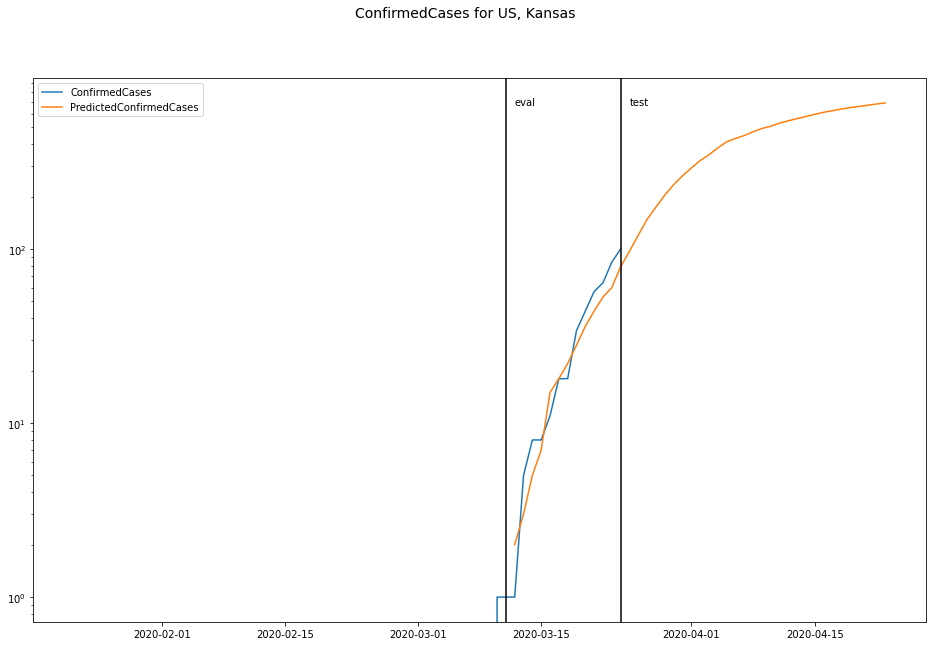

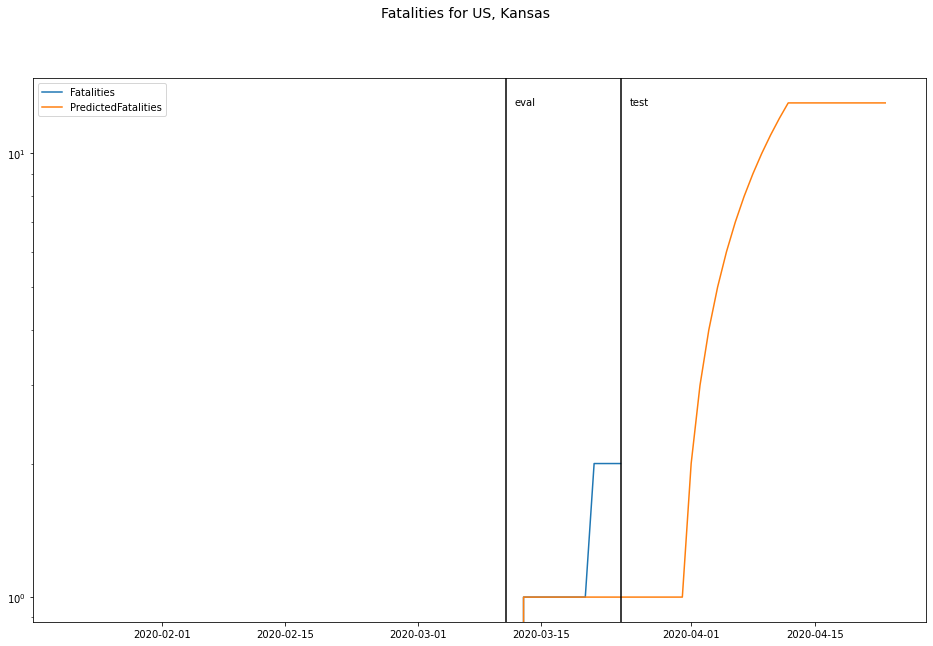

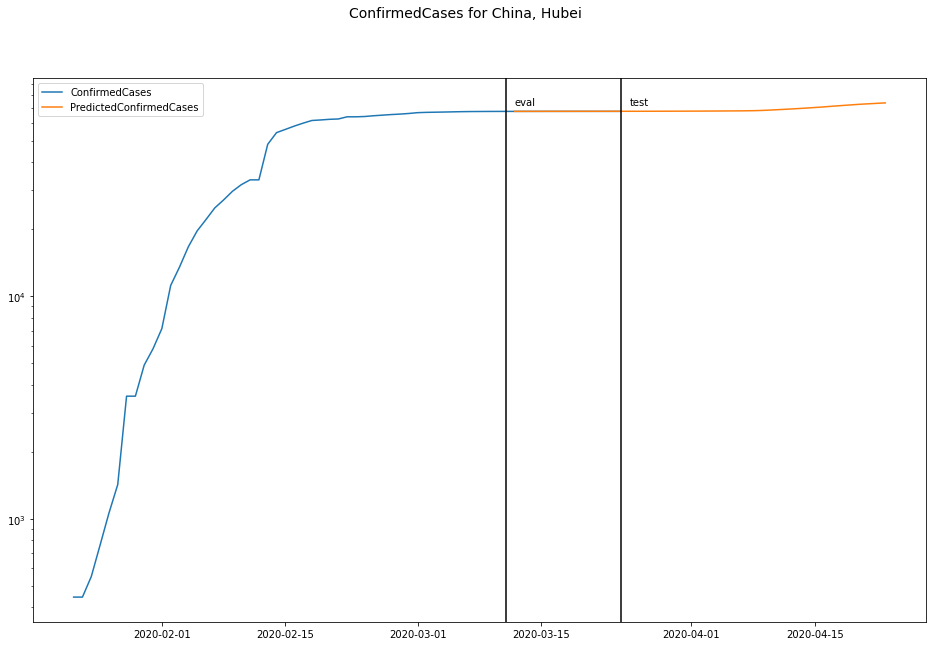

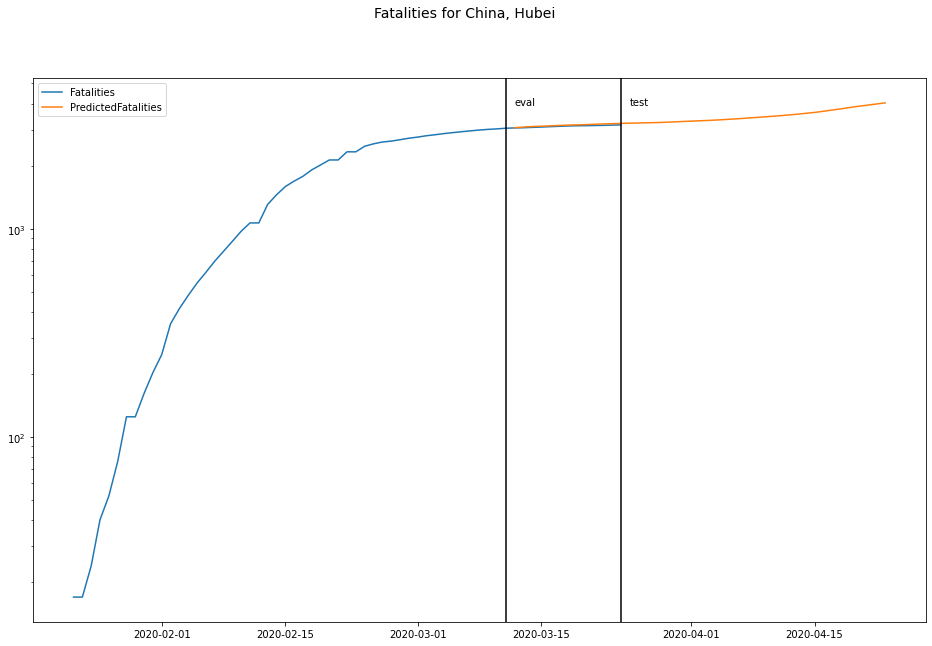

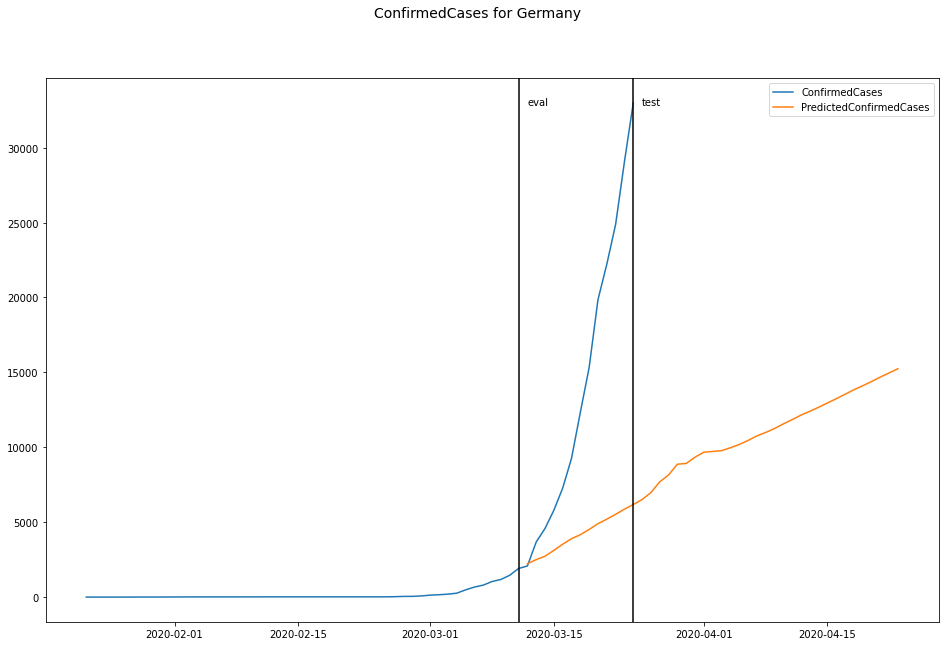

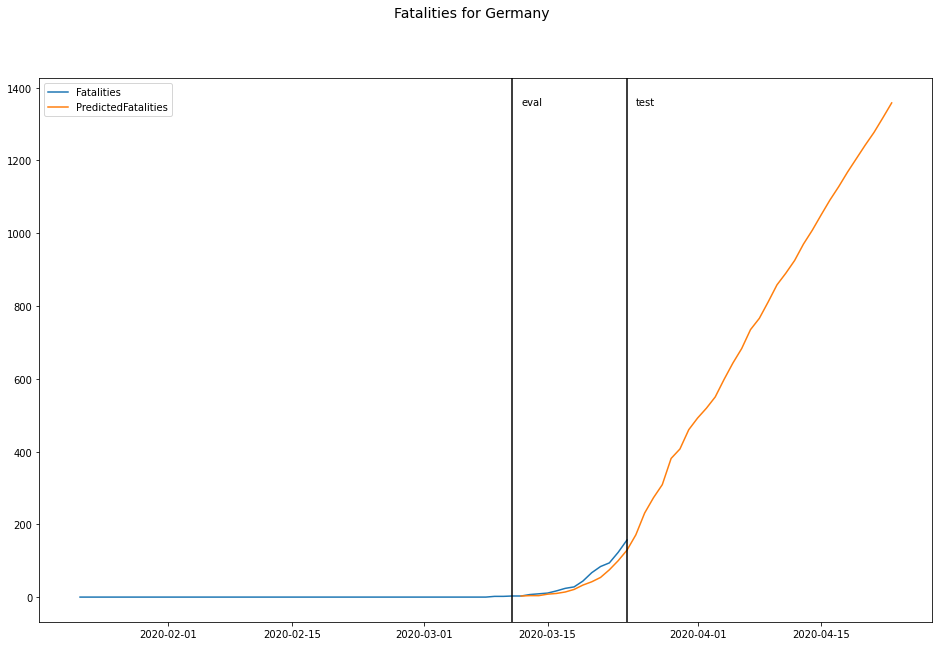

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib


def plot_graph(country_region, province_state, field, log_scale=True):
    location_df = main_df.loc[
        (main_df['Country/Region'] == country_region) & (main_df['Province/State'] == province_state)
    ]

    if province_state:
        title = '%s for %s, %s' % (field, country_region, province_state)
    else:
        title = '%s for %s' % (field, country_region)
    
    plt.figure(figsize = (16, 10))
    plt.suptitle(title, fontsize=14)
    if log_scale:
        plt.yscale('log')

    for sub_field in [field, 'Predicted' + field]:
        plt.plot(location_df['Date'], location_df[sub_field], label=sub_field)


    # add vertical lines splitting train, test and eval parts of the graph
    ax = plt.gca()

    # the x coords of this transformation are data, and the
    # y coord are axes
    transform_for_text = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)

    plt.axvline(x=last_train_date, color='#000000')
    plt.text(first_eval_date, 0.95, 'eval', transform = transform_for_text)
    plt.axvline(x=last_eval_date, color='#000000')
    plt.text(first_test_date, 0.95, 'test', transform = transform_for_text)


    plt.legend()
    plt.show()

plot_graph('US', 'Kansas', 'ConfirmedCases')
plot_graph('US', 'Kansas', 'Fatalities')
plot_graph('China', 'Hubei', 'ConfirmedCases')
plot_graph('China', 'Hubei', 'Fatalities')
plot_graph('Germany', '', 'ConfirmedCases', log_scale=False)
plot_graph('Germany', '', 'Fatalities', log_scale=False)